In [1]:
#!pip install keras_cv tensorflow-addons tfa-nightly
!pip install keras_cv tfa-nightly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.3/620.3 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 48.2 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [2]:
# Import necessary libraries
from datetime import datetime
from google.colab import drive, files
from keras import backend as K
from PIL import Image
from sklearn.metrics import (
    accuracy_score,  confusion_matrix, ConfusionMatrixDisplay,
    f1_score, precision_score, recall_score
)
from sklearn.model_selection import train_test_split
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import cv2
import keras_cv
import logging
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
import warnings

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.17.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

In [3]:
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 2


In [4]:
# Set seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(f"Keras version is: {tfk.__version__}")
print(f"Tensor flow version is: {tf.__version__}")
#print(f"Tensor flow addonsversion is: {tfa.__version__}")

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

Keras version is: 3.5.0
Tensor flow version is: 2.17.1


In [5]:
# Set batch size for training
BATCH_SIZE = 256

# Set learning rate for the optimiser
LEARNING_RATE = 1e-4

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000
#EPOCHS = 1

NUM_CLASSES = 5

In [6]:
#data = np.load("/kaggle/input/mars-dataset/mars_for_students.npz")
data = np.load("mars_for_students.npz")
training_set = data["training_set"]

X_train = training_set[:, 0] # Contains all the original images
y_train = training_set[:, 1] # Contains all the segmented images

X_test = data["test_set"]

In [7]:
def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        #num_classes = len(np.unique(label))
        #colormap = plt.cm.viridis(np.linspace(0, 1, num_classes))
        colormap = plt.cm.viridis(np.linspace(0, 1, NUM_CLASSES))

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

## Data cleaning

In [8]:
# Get the reference label (y_train[62]), it's the label representing the alien
reference_label = y_train[62]

# Filter the dataset where y_train is not equal to the reference label
mask = [not np.array_equal(label, reference_label) for label in y_train]

print(f"Original dataset size: {len(X_train)}")

# We keep only the entries not equal to reference_label
X_train = X_train[mask]
y_train = y_train[mask]

print(f"Filtered dataset size: {len(X_train)}")

Original dataset size: 2615
Filtered dataset size: 2505


In [9]:
# Code to save on disk bad images with class 4
from PIL import Image

idx_extract = [57,140,162,382,406,470,475,614,737,872,922,985,1026,1125,1162,1168, 1266,1337,1456,1475,1491,1526,1544,1633,1684,1792,1883,1919,2193,2199,2351]

images_extract = X_train[idx_extract]

# save the images in jpeg format
for i, image in enumerate(images_extract):
    img = Image.fromarray(image)

    # Check the mode of the image and convert if necessary
    if img.mode != 'RGB':
        img = img.convert('RGB')  # Convert to RGB if not already in that mode

    img.save(f"Dataset_images/{i}.jpeg")

In [10]:
import matplotlib.pyplot as plt

# Code to show such bad images with class 4
# Supponiamo che X_train contenga le immagini e y_train le etichette di segmentazione
for i, (img_batch, lbl_batch) in enumerate(zip(X_train, y_train)):
    # Check if any pixel in the label belongs to class 4
    if np.any(lbl_batch == 4):  # Check if class 4 is present in the label
        print(f"Img {i} contains class 4")

        # Plot original image
        plt.figure(figsize=(8, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(img_batch, cmap='gray' if len(img_batch.shape) == 2 else None)
        plt.title("Picture")
        plt.axis('off')

        # Apply the colormap to the segmentation labels
        colormap = plt.cm.viridis(np.linspace(0, 1, 5))

        plt.subplot(1, 2, 2)
        colored_label = apply_colormap(lbl_batch, colormap)
        plt.imshow(colored_label, cmap='viridis')
        plt.title("Label (Segmentation)")
        plt.axis('off')

        plt.show()

Output hidden; open in https://colab.research.google.com to view.

Img 0 contains class 4


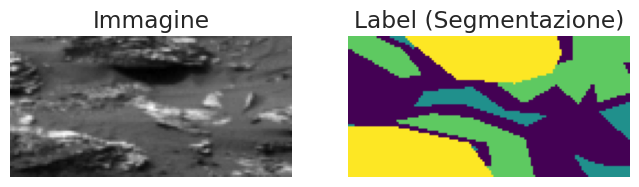

Img 1 contains class 4


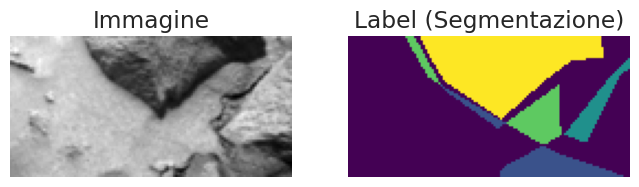

Img 2 contains class 4


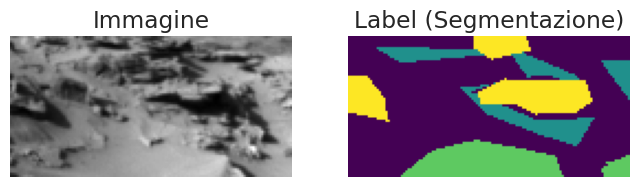

Img 3 contains class 4


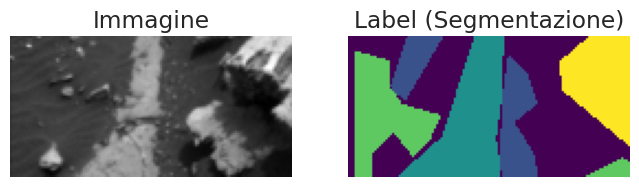

Img 4 contains class 4


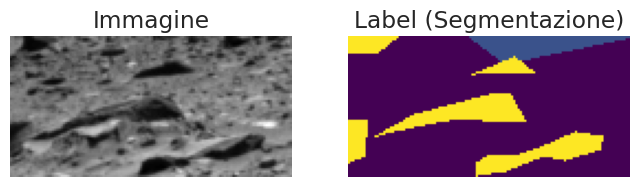

Img 5 contains class 4


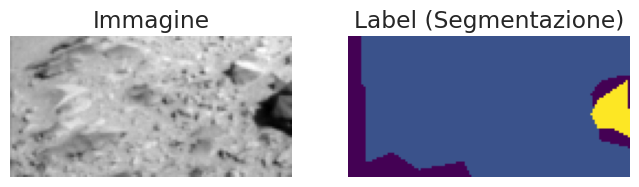

Img 6 contains class 4


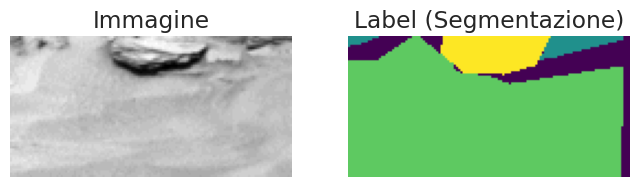

Img 7 contains class 4


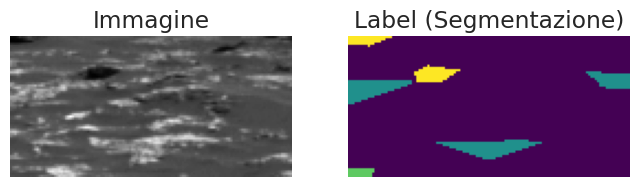

Img 8 contains class 4


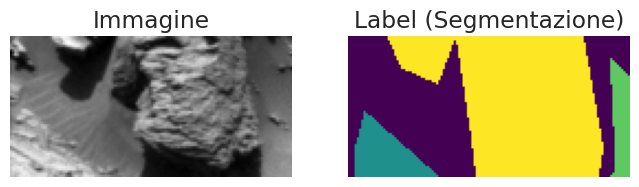

Img 9 contains class 4


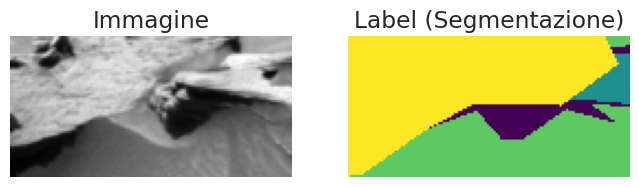

Img 10 contains class 4


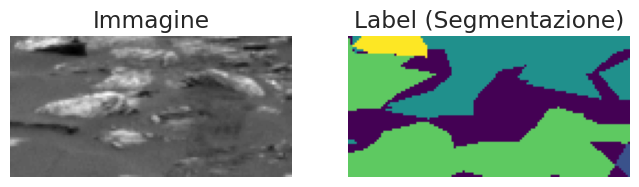

Img 11 contains class 4


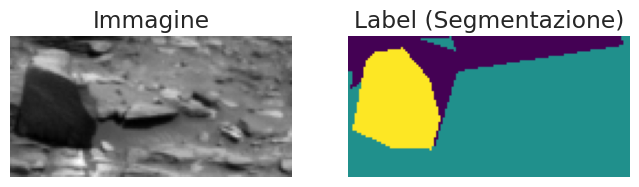

Img 12 contains class 4


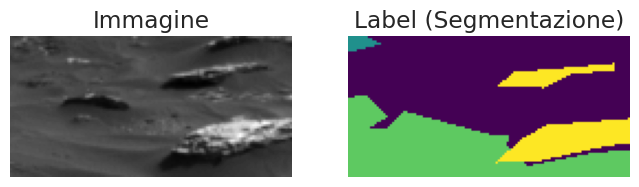

Img 13 contains class 4


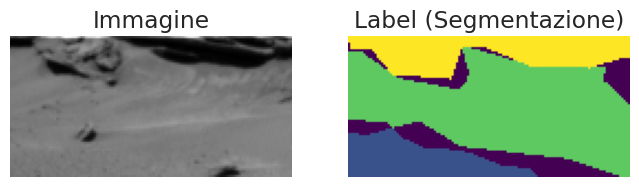

Img 14 contains class 4


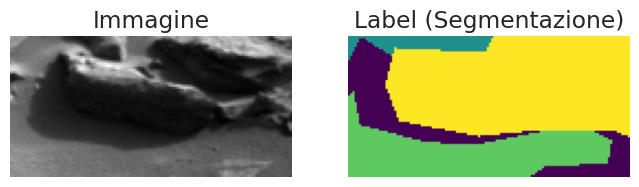

Img 15 contains class 4


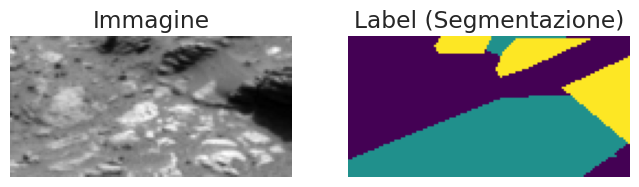

Img 16 contains class 4


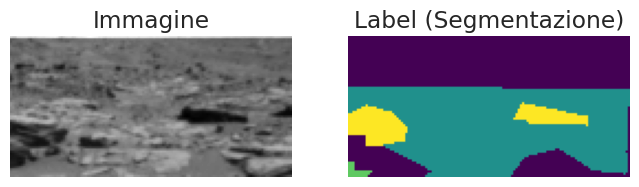

Img 17 contains class 4


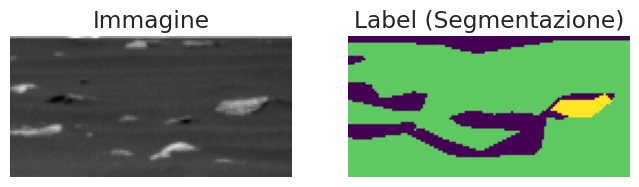

Img 18 contains class 4


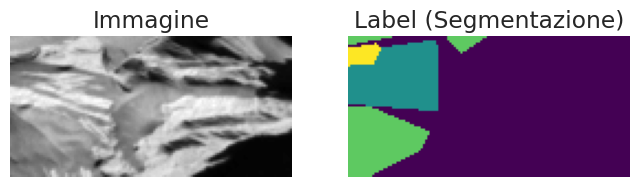

Img 19 contains class 4


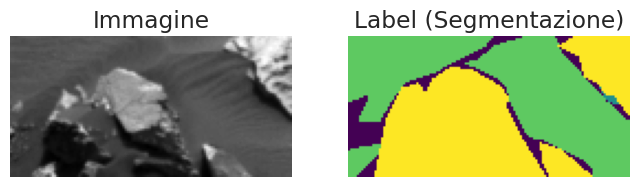

Img 20 contains class 4


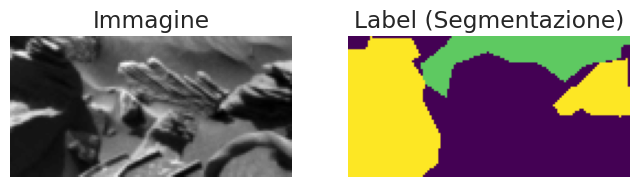

Img 21 contains class 4


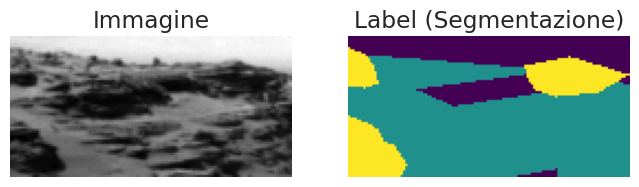

Img 22 contains class 4


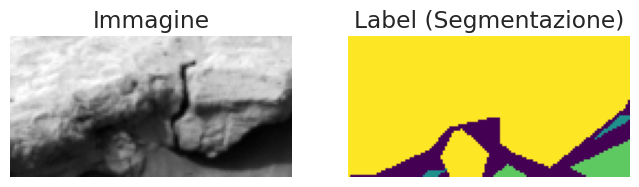

Img 23 contains class 4


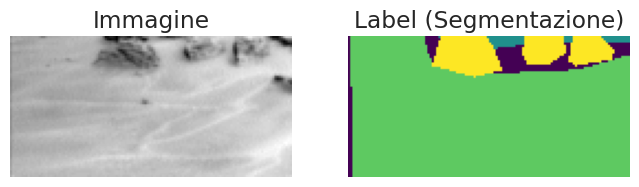

Img 24 contains class 4


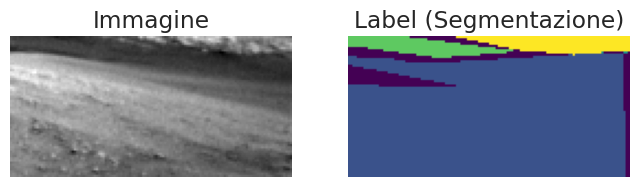

Img 25 contains class 4


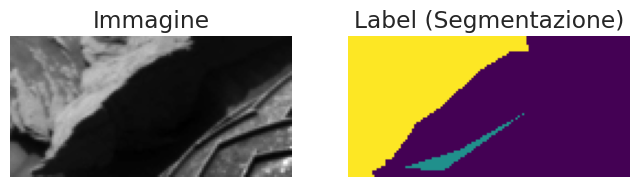

Img 26 contains class 4


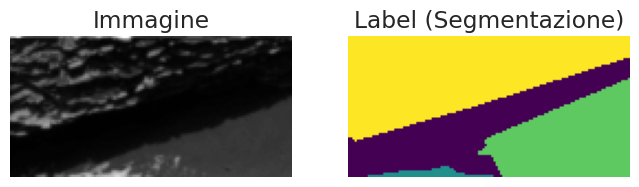

Img 27 contains class 4


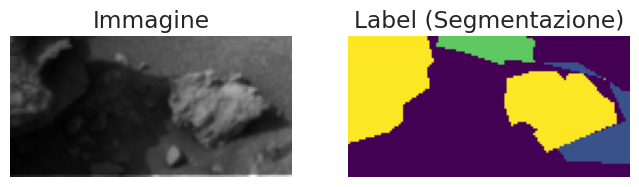

Img 28 contains class 4


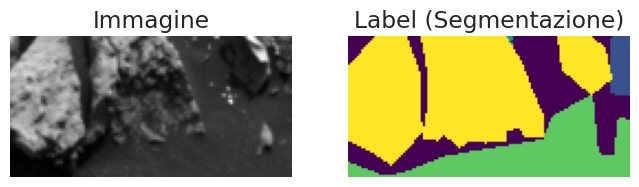

Img 29 contains class 4


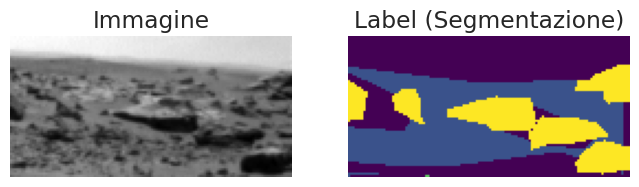

Img 30 contains class 4


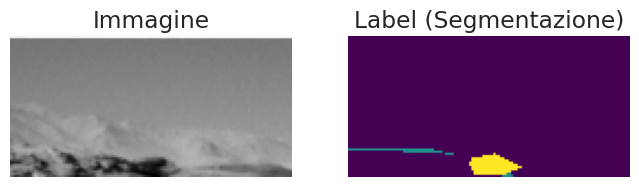

Filtered dataset size: 2505


In [11]:
import json
import numpy as np
from PIL import Image, ImageDraw

# Code to join our handmade labels with the existing ones
def remove_label(label, label_to_remove=4):
    """
    #Remove a specific label from the label map.
    """
    # Create a copy of the label map
    label = np.copy(label)

    # Set the label to remove to 0
    label[label == label_to_remove] = 0

    return label

for i in range(len(idx_extract)):
    idx_original = idx_extract[i]

    # Carica il file JSON di Labelme
    with open("Dataset_labels/"+str(i)+".json", "r") as f:
        labelme_data = json.load(f)

    # Parametri
    label_value = 4  # Etichetta per "big_rock"
    image_width = 128
    image_height = 64

    # Inizializza una maschera vuota
    new_mask = np.zeros((image_height, image_width), dtype=np.uint8)

    # Processa tutte le shape nel JSON
    for shape in labelme_data["shapes"]:
        if shape["label"] == "big_rock":  # Considera solo le label "big_rock"
            # Crea un poligono a partire dai punti
            polygon = shape["points"]
            polygon = [(int(x), int(y)) for x, y in shape["points"]]


            # Usa PIL per disegnare il poligono sulla maschera
            img = Image.new("L", (image_width, image_height), 0)
            ImageDraw.Draw(img).polygon(polygon, outline=label_value, fill=label_value)
            new_mask += np.array(img, dtype=np.uint8)  # Sovrapponi alla maschera

    # Carica la maschera originale
    original_mask = remove_label(y_train[idx_original])

    # Sovrapponi la maschera nuova alla maschera originale
    # Sovrascrivi solo i pixel corrispondenti a `big_rock`
    combined_mask = np.where(new_mask == label_value, label_value, original_mask)

    y_train[idx_original] = combined_mask

    print(f"Img {i} contains class 4")

    # Plot original image
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(X_train[idx_original], cmap='gray')
    plt.title("Immagine")
    plt.axis('off')

    # Apply the colormap to the segmentation labels
    colormap = plt.cm.viridis(np.linspace(0, 1, 5))

    plt.subplot(1, 2, 2)
    colored_label = apply_colormap(combined_mask, colormap)
    plt.imshow(colored_label, cmap='viridis')
    plt.title("Label (Segmentazione)")
    plt.axis('off')

    plt.show()

print(f"Filtered dataset size: {len(X_train)}")

In [12]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=seed
)

Img 2063


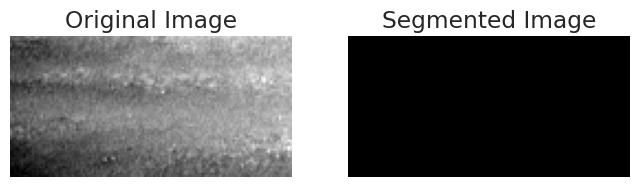

Img 1263


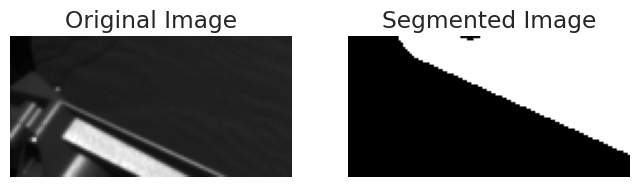

Img 2127


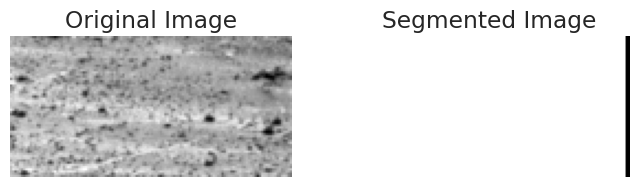

Img 599


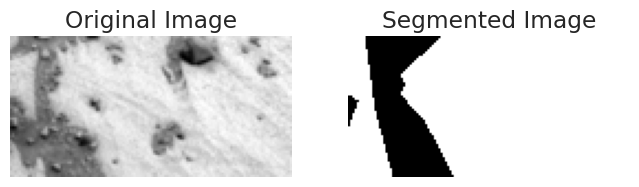

Img 464


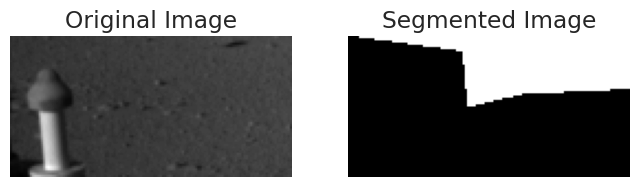

Img 1264


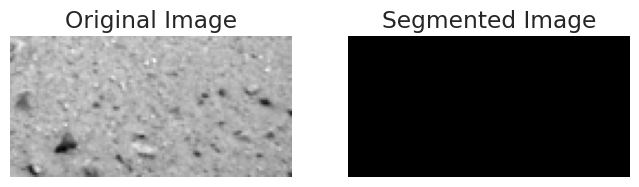

Img 1602


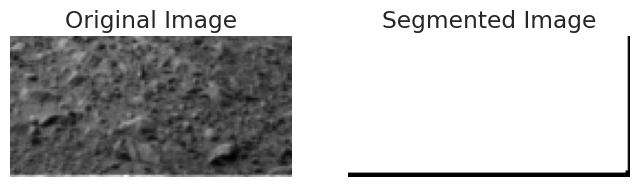

Img 1962


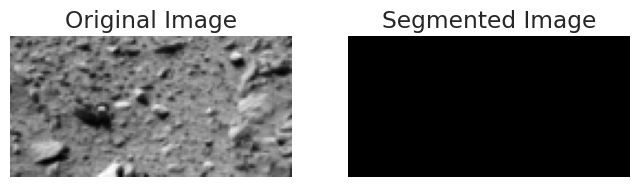

Img 1753


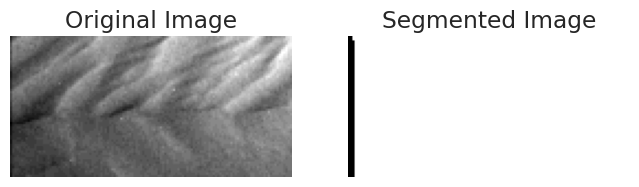

Img 1270


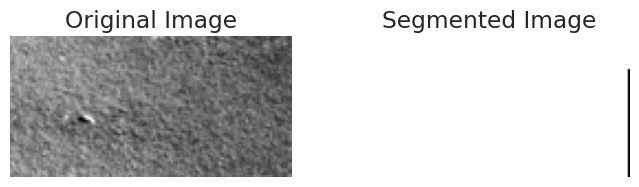

In [13]:
# Randomly sample 10 indices
random_indices = np.random.choice(len(X_train), size=10, replace=False)

# Loop through the randomly selected images
for i, idx in enumerate(random_indices):
    img = X_train[idx]
    label = y_train[idx]

    plt.figure(figsize=(8, 4))

    print(f"Img {idx}")

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
    plt.title("Original Image")
    plt.axis('off')

    # Segmented Image
    plt.subplot(1, 2, 2)
    plt.imshow(label, cmap='gray' if len(label.shape) == 2 else None)
    plt.title("Segmented Image")
    plt.axis('off')

    plt.show()

In [14]:
import numpy as np

# Code to remove those pictures which have less than threshold_percentage (3%) of class 4 pixels
# Parametri
label_value = 4  # Label di interesse
threshold_percentage = 3  # Soglia in percentuale

# Inizializza le nuove liste per filtrare i dati
X_train_filtered = []
y_train_filtered = []

# Itera su tutte le immagini e maschere
for i, (img_batch, lbl_batch) in enumerate(zip(X_train, y_train)):
    # Check if any pixel in the label belongs to class 4
    if np.any(lbl_batch == 4):  # Check if class 4 is present in the label

        total_pixels = 64 * 128
        label_pixels = np.sum(lbl_batch == label_value)
        label_percentage = (label_pixels / total_pixels) * 100

        # Mantieni solo immagini con label sopra la soglia
        if label_percentage >= threshold_percentage:
            X_train_filtered.append(img_batch)
            y_train_filtered.append(lbl_batch)
        else:
            print(f"Rimosso: label_value = {label_value}, {label_percentage:.2f}%")
    else:
        X_train_filtered.append(img_batch)
        y_train_filtered.append(lbl_batch)

# Converti le liste filtrate in array NumPy
X_train = np.array(X_train_filtered)
y_train = np.array(y_train_filtered)

print(f"Dataset filtrato: {X_train.shape[0]} immagini rimanenti.")

Rimosso: label_value = 4, 1.94%
Rimosso: label_value = 4, 0.02%
Rimosso: label_value = 4, 2.12%
Rimosso: label_value = 4, 1.72%
Rimosso: label_value = 4, 0.05%
Rimosso: label_value = 4, 1.46%
Rimosso: label_value = 4, 0.06%
Rimosso: label_value = 4, 1.44%
Rimosso: label_value = 4, 2.11%
Rimosso: label_value = 4, 2.73%
Rimosso: label_value = 4, 1.66%
Rimosso: label_value = 4, 1.79%
Rimosso: label_value = 4, 0.02%
Rimosso: label_value = 4, 1.43%
Rimosso: label_value = 4, 2.43%
Rimosso: label_value = 4, 0.01%
Rimosso: label_value = 4, 1.99%
Rimosso: label_value = 4, 2.33%
Rimosso: label_value = 4, 2.62%
Dataset filtrato: 2235 immagini rimanenti.


In [15]:
"""from collections import Counter

# Iterate through each image in y_train
for i in range(y_train.shape[0]):
    percentage_threshold = 40
    image = y_train[i]  # Extract the current image (64x128)

    # Flatten the image to calculate pixel frequencies
    flat_image = image.flatten()

    # Count occurrences of each class
    class_counts = Counter(flat_image)

    # Check if class 0 exists in the image
    if 0 in class_counts:
        # Calculate the percentage of class 0 pixels
        total_pixels = flat_image.size
        class_0_percentage = class_counts[0] / total_pixels * 100

        # If class 0 percentage is less than 40%, replace it with the majority class
        if class_0_percentage < percentage_threshold:
            # Find the majority class (excluding class 0)
            majority_class = max(
                (cls for cls in class_counts if cls != 0),
                key=lambda cls: class_counts[cls]
            )

            # Replace all class 0 pixels with the majority class
            image[image == 0] = majority_class

    # Update the processed image back into y_train
    y_train[i] = image"""

'from collections import Counter\n\n# Iterate through each image in y_train\nfor i in range(y_train.shape[0]):\n    percentage_threshold = 40\n    image = y_train[i]  # Extract the current image (64x128)\n\n    # Flatten the image to calculate pixel frequencies\n    flat_image = image.flatten()\n\n    # Count occurrences of each class\n    class_counts = Counter(flat_image)\n\n    # Check if class 0 exists in the image\n    if 0 in class_counts:\n        # Calculate the percentage of class 0 pixels\n        total_pixels = flat_image.size\n        class_0_percentage = class_counts[0] / total_pixels * 100\n\n        # If class 0 percentage is less than 40%, replace it with the majority class\n        if class_0_percentage < percentage_threshold:\n            # Find the majority class (excluding class 0)\n            majority_class = max(\n                (cls for cls in class_counts if cls != 0),\n                key=lambda cls: class_counts[cls]\n            )\n\n            # Replace a

In [16]:
def cleaning_background(label):

     # Conta il numero di pixel per ciascuna classe
    unique, counts = np.unique(label, return_counts=True)
    class_counts = dict(zip(unique, counts))

    # Rimuove la classe 0 dai conteggi per trovare la classe maggioritaria
    class_counts.pop(0, None)  # Ignora la classe 0
    if class_counts:
        # Trova la classe maggioritaria
        major_class = max(class_counts, key=class_counts.get)
    else:
        # Se l'unica classe presente è la 0, sostituisci con la classe 1
        major_class = 1

    # Sostituisci i pixel della classe 0 con la classe maggioritaria
    updated_label = np.where(label == 0, major_class, label)

    return updated_label

341
Img 0 contains background


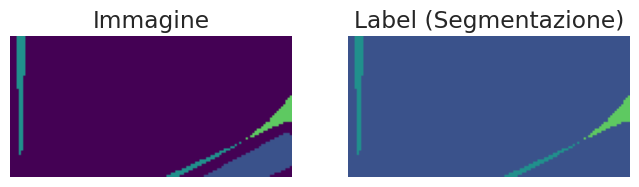

Img 1 contains background


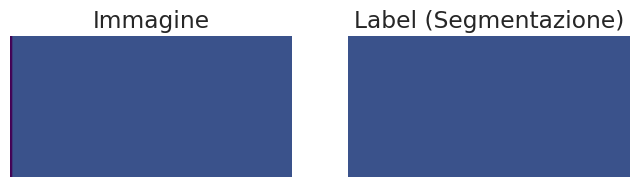

Img 2 contains background


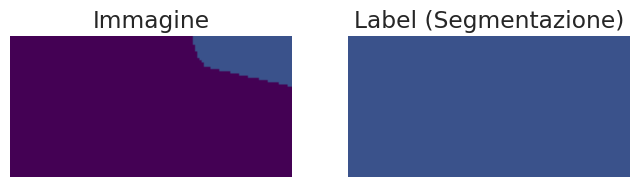

Img 4 contains background


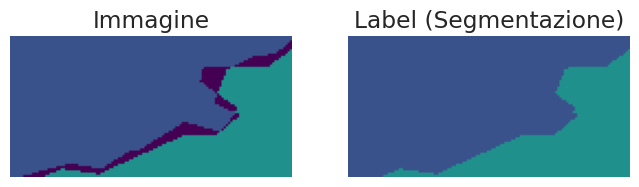

Img 5 contains background


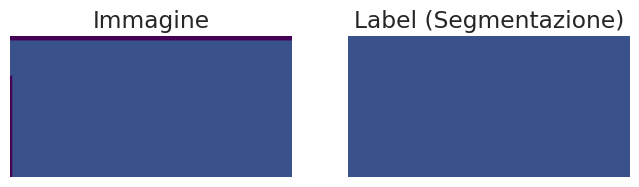

Img 6 contains background


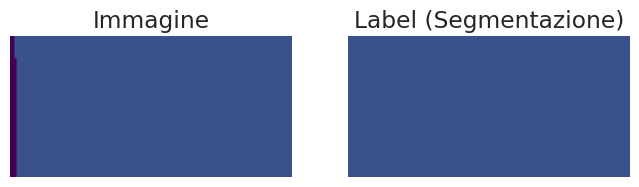

Img 7 contains background


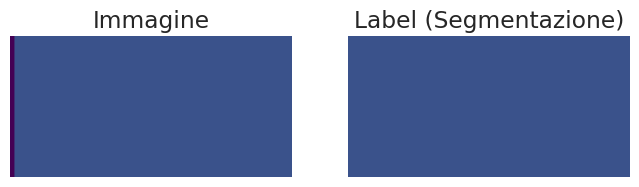

Img 8 contains background


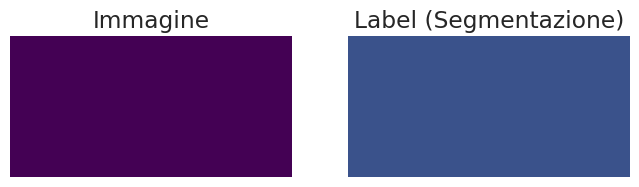

Img 11 contains background


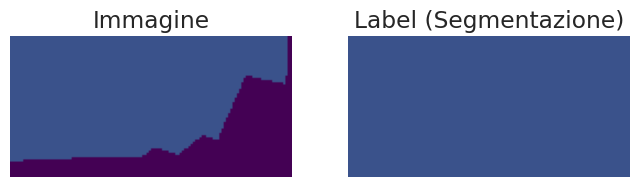

Img 12 contains background


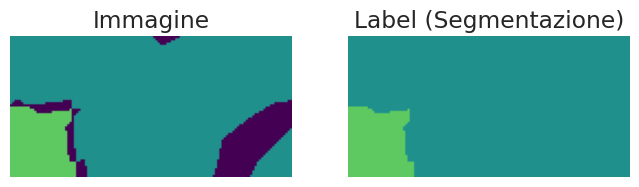

Img 13 contains background


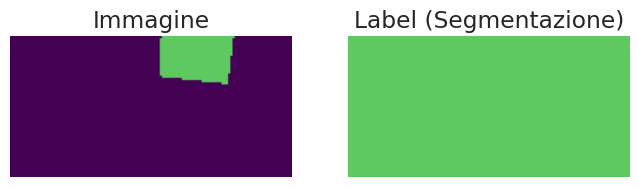

Img 14 contains background


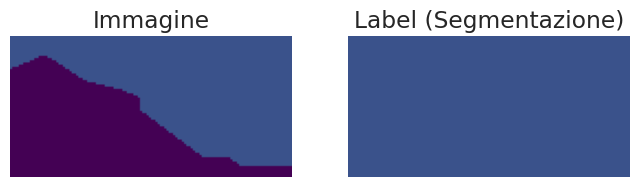

Img 16 contains background


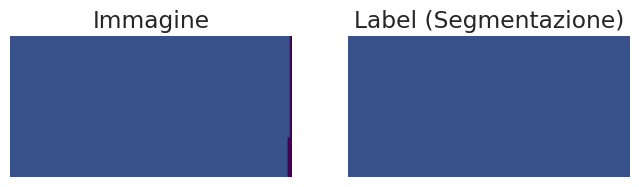

Img 18 contains background


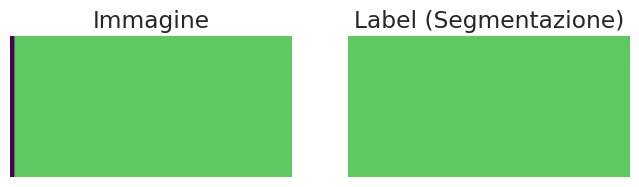

Img 20 contains background


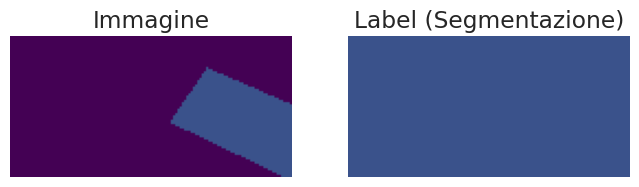

Img 21 contains background


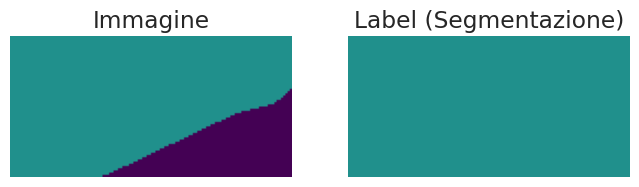

Img 22 contains background


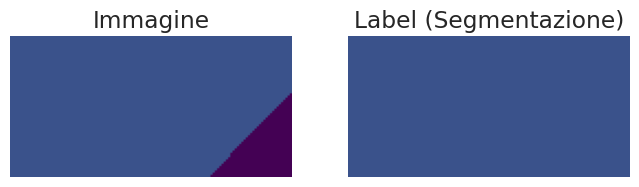

Img 23 contains background


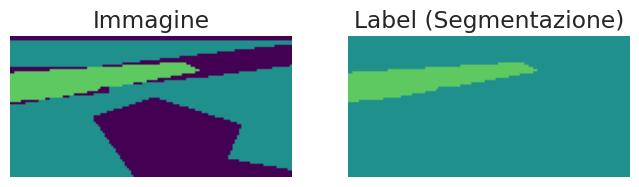

Img 24 contains background


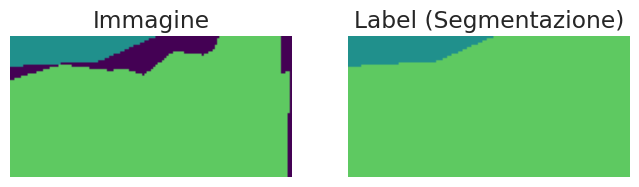

Img 25 contains background


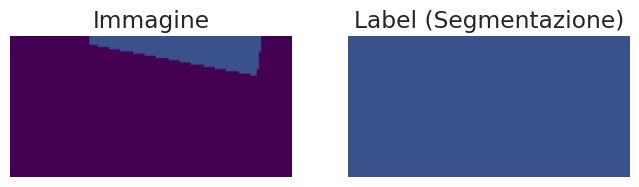

Img 26 contains background


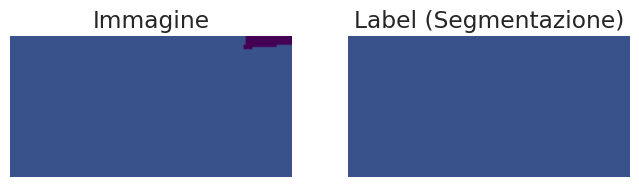

Img 27 contains background


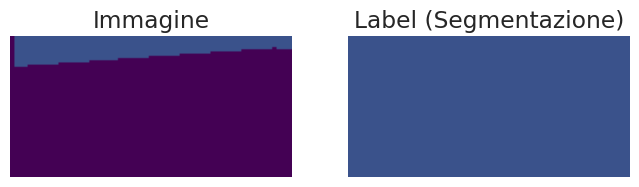

Img 29 contains background


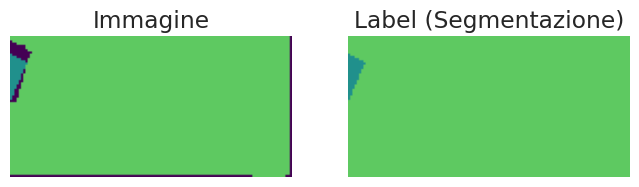

Img 30 contains background


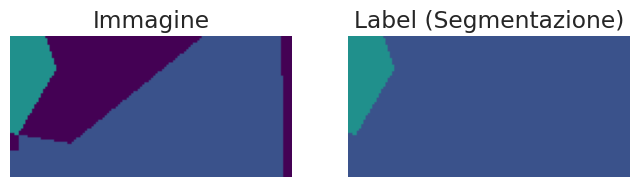

Img 31 contains background


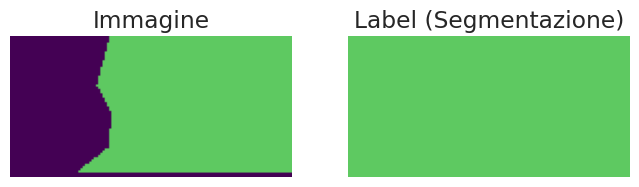

Img 33 contains background


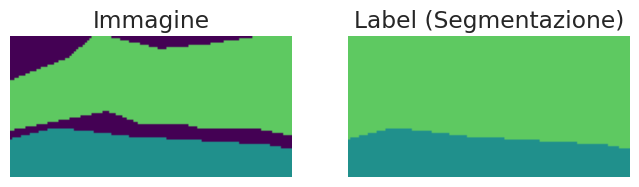

Img 34 contains background


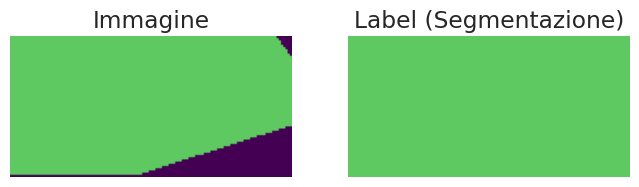

Img 35 contains background


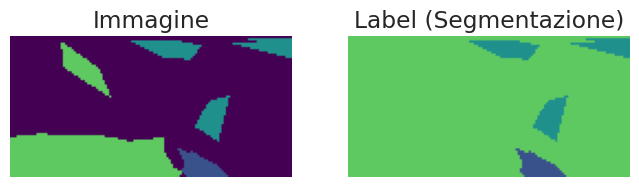

Img 36 contains background


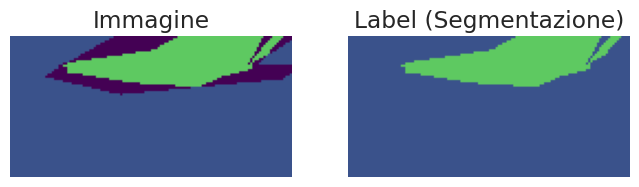

Img 37 contains background


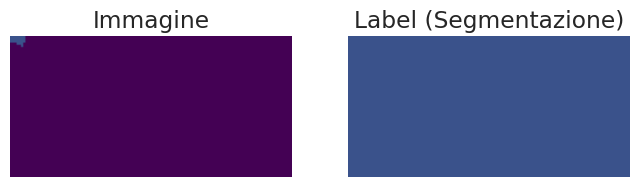

Img 40 contains background


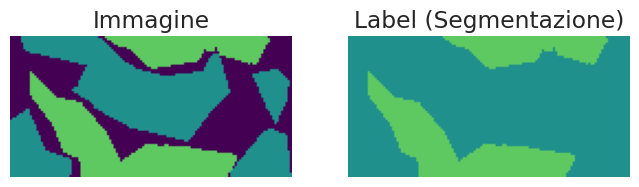

Img 41 contains background


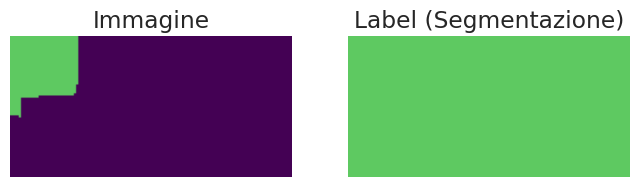

Img 42 contains background


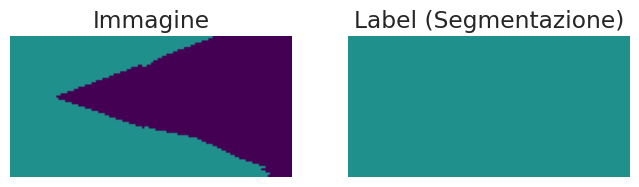

Img 43 contains background


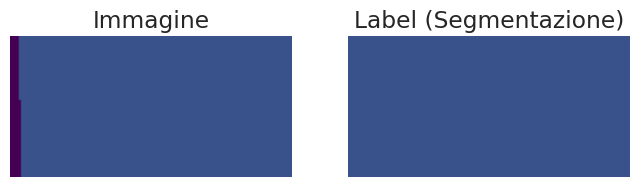

Img 44 contains background


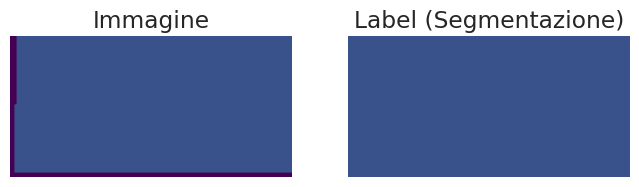

Img 45 contains background


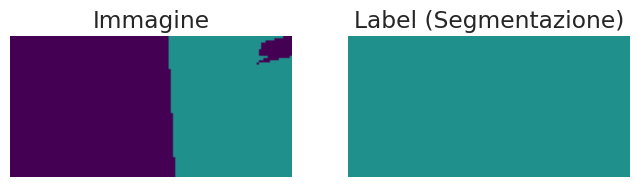

Img 46 contains background


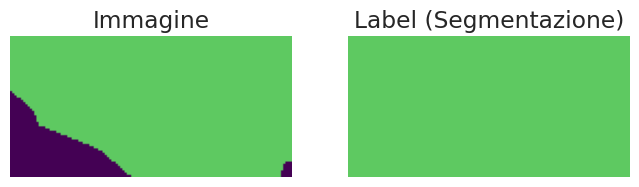

Img 47 contains background


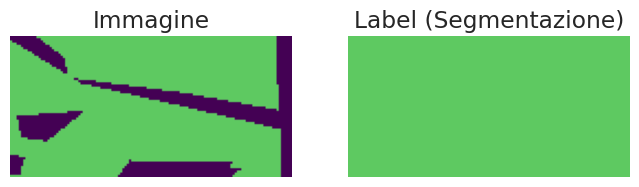

Img 48 contains background


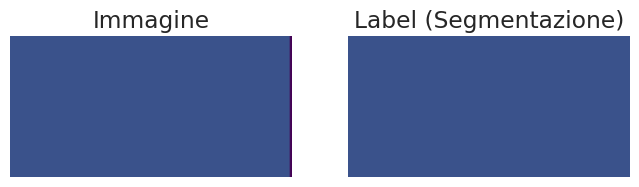

Img 49 contains background


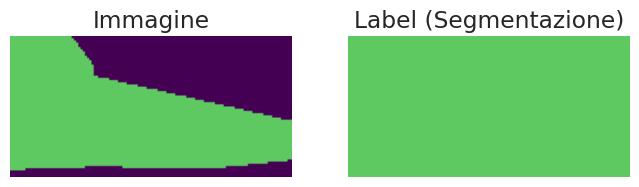

Img 50 contains background
Img 51 contains background
Img 52 contains background
Img 53 contains background
Img 54 contains background
Img 55 contains background
Img 56 contains background
Img 57 contains background
Img 58 contains background
Img 59 contains background
Img 60 contains background
Img 61 contains background
Img 62 contains background
Img 63 contains background
Img 64 contains background
Img 65 contains background
Img 66 contains background
Img 67 contains background
Img 68 contains background
Img 69 contains background
Img 72 contains background
Img 73 contains background
Img 76 contains background
Img 77 contains background
Img 78 contains background
Img 79 contains background
Img 80 contains background
Img 81 contains background
Img 82 contains background
Img 83 contains background
Img 84 contains background
Img 85 contains background
Img 86 contains background
Img 87 contains background
Img 88 contains background
Img 89 contains background
Img 90 contains background
I

In [17]:
idx_background = [10, 11,12,15,23,26, 32,35,49,57,58,67,72,76,
                  84,90,105,106,115,116,133,140,145,149,158,162,164,166,170,182,191,194,
                  201,202,208,212,214,226,237,241,261,266,270,273,280,287,290,297,307,308,321,
                  325,326,339,342,364,368,382,385,386,388,397,399,406,414,423,427,428,
                  432,439,441,445,446,452,458,471,480,495,497,499,502,513,545,547,556,557,564,
                  560,591,601,602,605,614,626,632,654,655,660,674,683,685,692,693,698,
                  711,726,737,742,748,760,766,769,787,794,795,797,804,807,813,816,
                  824,833,843,848,850,851,867,868,872,873,874,881,882,887,888,915,918,920,
                  927,930,935,937,942,948,955,956,957,960,990,999,1022,1023,1026,1028,1030,1035,
                  1037,1040,1050,1060,1068,1079,1083,1085,1097,1099,1123,1141,1143,1156,1162,
                  1168,1173,1187,1193,1199,1200,1201,1204,1212,1219,1220,1225,1228,1231,
                  1233,1238,1246,1266,1282,1283,1311,1316,1318,1326,1332,1336,1344,1349,
                  1357,1372,1386,1403,1415,1426,1443,1456,1462,1464,1466,1469,1474,1491,1498,
                  1501,1508,1510,1514,1527,1534,1539,1540,1544,1548,1569,1572,1576,1585,
                  1587,1590,1593,1609,1617,1618,1627,1632,1646,1656,1681,1698,1702,1708,
                  1712,1751,1755,1756,1781,1786,1795,1808,1818,1824,1826,1832,1839,1841,
                  1853,1854,1866,1872,1900,1913,1917,1919,1942,1947,1952,1955,1960,1967,
                  1978,1982,1986,1990,1991,2000,2002,2003,2004,2014,2024,2029,2034,2048,
                  2050,2064,2065,2070,2071,2079,2087,2091,2106,2111,2115,2123,2124,2149,
                  2160,2163,2168,2171,2184,2185,2192,2193,2197,2199,2218,2225,2232,2234,
                  2246,2247,2253,2266,2287,2301,2308,2311,2313,2330,2331,2337,2354,2363,2365,
                  2369,2383,2399,2406,2409,2412,2414,2420,2432,2445,2451,2456,2473,2498]

print(len(idx_background))

import numpy as np

# Parametri
label_value = 0  # Label di interesse
threshold_percentage = 100

# Itera su tutte le immagini e maschere
for i, (img_batch, lbl_batch) in enumerate(zip(X_train, y_train)):
    # Check if any pixel in the label belongs to class 4
    if np.any(lbl_batch == label_value):  # Check if class 4 is present in the label

        total_pixels = 64 * 128
        label_pixels = np.sum(lbl_batch == label_value)
        label_percentage = (label_pixels / total_pixels) * 100

        if (label_percentage > 0.0) and ((label_percentage <= threshold_percentage) or i in idx_background):
            new_label = cleaning_background(lbl_batch)
            print(f"Img {i} contains background")

            if i < 50:
                # Apply the colormap to the segmentation labels
                colormap = plt.cm.viridis(np.linspace(0, 1, 5))

                # Plot original image
                plt.figure(figsize=(8, 4))

                plt.subplot(1, 2, 1)
                colored_label = apply_colormap(lbl_batch, colormap)
                plt.imshow(colored_label, cmap='viridis')
                plt.title("Immagine")
                plt.axis('off')


                plt.subplot(1, 2, 2)
                colored_label = apply_colormap(new_label, colormap)
                plt.imshow(colored_label, cmap='viridis')
                plt.title("Label (Segmentazione)")
                plt.axis('off')

                plt.show()

            y_train[i] = new_label


In [18]:
def calculate_class_percentage(y_train):
    # Flatten y_train to aggregate pixel counts across all segmented images
    all_pixels = np.concatenate([y.flatten() for y in y_train])

    # Count the occurrences of each class
    unique_classes, counts = np.unique(all_pixels, return_counts=True)

    # Calculate the total number of pixels
    total_pixels = all_pixels.size

    # Calculate the percentage of each class
    class_percentages = {cls: (count / total_pixels) * 100 for cls, count in zip(unique_classes, counts)}

    return class_percentages

class_percentages = calculate_class_percentage(y_train)

# Print results
print("Class percentages:")
for cls, percentage in class_percentages.items():
    print(f"Class {cls}: {percentage:.2f}%")

Class percentages:
Class 1.0: 43.35%
Class 2.0: 31.97%
Class 3.0: 24.01%
Class 4.0: 0.68%


In [19]:
from tensorflow_addons.layers import GroupNormalization

def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        #x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = GroupNormalization(groups=8, axis=-1, name=f"{name}_gn1" + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [20]:
def augmentation_layer():
    return tf.keras.Sequential(
        [
          tf.keras.layers.RandomBrightness(factor=0.1),
          keras_cv.layers.RandomContrast(value_range=[0, 255], factor=0.2),
          keras_cv.layers.RandomGaussianBlur(kernel_size=2, factor=1),
          tf.keras.layers.GaussianNoise(stddev=0.05),

          #keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),
          #keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),
          #keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),
          #keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),
          #keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),
        ]
    )

In [21]:
def squeeze_and_excitation_block(input_tensor, reduction_ratio=16, name='SE_block'):
    """Adds a squeeze-and-excitation block."""
    filters = input_tensor.shape[-1]  # Number of filters in the input
    se = tfkl.GlobalAveragePooling2D(name=name + '_gap')(input_tensor)  # Squeeze: global context
    se = tfkl.Dense(filters // reduction_ratio, activation='relu', name=name + '_fc1')(se)  # Excitation: dense layer 1
    se = tfkl.Dense(filters, activation='sigmoid', name=name + '_fc2')(se)  # Excitation: dense layer 2
    se = tfkl.Multiply(name=name + '_scale')([input_tensor, se])  # Reweight feature maps
    return se

In [22]:
def cross_branch_attention(encoder_feature, decoder_feature):
    # Generate attention map using encoder features
    attention_map = tfkl.Conv2D(1, kernel_size=1, activation='sigmoid')(encoder_feature)

    # Reweight encoder features
    weighted_encoder = tfkl.Multiply()([encoder_feature, attention_map])

    # Fuse with decoder features
    fused_features = tfkl.Concatenate()([weighted_encoder, decoder_feature])
    return fused_features

In [23]:
class AdaptiveFusion(tf.keras.layers.Layer):
    def __init__(self, units, activation="sigmoid", **kwargs):
        super(AdaptiveFusion, self).__init__(**kwargs)
        self.dense = tf.keras.layers.Dense(units, activation=activation)

    def call(self, inputs):
        # Stack inputs along the last axis
        stacked_inputs = tf.stack(inputs, axis=-1)

        # Compute adaptive gates (one per input)
        gates = self.dense(stacked_inputs)
        gates = tf.nn.softmax(gates, axis=-1)  # Normalize gates

        # Weighted sum of inputs
        return tf.reduce_sum(gates * stacked_inputs, axis=-1)

In [24]:
def MiniASPP(input_tensor, filters=256, rate1=1, rate2=2):
    """
    Builds a simplified Mini-ASPP module.

    Parameters:
        input_tensor: Input tensor to the Mini-ASPP module.
        filters: Number of filters for each convolution.
        rate1: Dilation rate for the first 3x3 convolution.
        rate2: Dilation rate for the second 3x3 convolution.

    Returns:
        Tensor: Output of the Mini-ASPP module.
    """
    # 1x1 Convolution
    conv_1x1 = tfkl.Conv2D(filters, kernel_size=1, padding="same", activation="relu")(input_tensor)

    # 3x3 Convolution with dilation rate `rate1`
    conv_3x3_rate1 = tfkl.Conv2D(filters, kernel_size=3, dilation_rate=rate1, padding="same", activation="relu")(input_tensor)

    # 3x3 Convolution with dilation rate `rate2`
    conv_3x3_rate2 = tfkl.Conv2D(filters, kernel_size=3, dilation_rate=rate2, padding="same", activation="relu")(input_tensor)

    # Concatenate all branches
    concatenated = tfkl.Concatenate()([conv_1x1, conv_3x3_rate1, conv_3x3_rate2])

    # Final 1x1 Convolution to reduce the depth
    output = tfkl.Conv2D(filters, kernel_size=1, padding="same", activation="relu")(concatenated)

    return output

In [25]:
class MatMulLayer(tfkl.Layer):
    def __init__(self, transpose_b=False, **kwargs):
        super(MatMulLayer, self).__init__(**kwargs)
        self.transpose_b = transpose_b

    def call(self, inputs):
        a, b = inputs
        return tf.matmul(a, b, transpose_b=self.transpose_b)

In [54]:
def PSA_Module(input_tensor):
    """
    Implements the Polarized Self-Attention (PSA) mechanism as shown in the diagram.

    Parameters:
        input_tensor: Input tensor of shape (H, W, C).

    Returns:
        Tensor: Output tensor of the same shape as the input.
    """
    input_channels = input_tensor.shape[-1]
    #print(input_channels)
    #reduced_channels = input_channels // 2  # Reduce channels by half for intermediate computations
    reduced_channels = max(1, input_channels // 2)

    # ======== Spatial Attention Branch ========
    # Query (Q) and Value (V)
    Q_spatial = tfkl.Conv2D(reduced_channels, kernel_size=1, padding="same")(input_tensor)
    V_spatial = tfkl.Conv2D(reduced_channels, kernel_size=1, padding="same")(input_tensor)

    # Reshape for attention calculation
    Q_spatial_reshaped = tfkl.Reshape((-1, reduced_channels))(Q_spatial)  # Shape: (HW, C/2)
    V_spatial_reshaped = tfkl.Reshape((reduced_channels, -1))(V_spatial)  # Shape: (C/2, HW)

    # Attention map
    #attention_map_spatial = tf.matmul(Q_spatial_reshaped, V_spatial_reshaped)  # Shape: (HW, HW)
    attention_map_spatial = MatMulLayer()([Q_spatial_reshaped, V_spatial_reshaped])
    attention_map_spatial = tfkl.Softmax(axis=-1)(attention_map_spatial)

    # Refine spatial features
    #refined_spatial = tf.matmul(attention_map_spatial, Q_spatial_reshaped)  # Shape: (HW, C/2)
    refined_spatial = MatMulLayer()([attention_map_spatial, Q_spatial_reshaped])
    refined_spatial = tfkl.Reshape((input_tensor.shape[1], input_tensor.shape[2], reduced_channels))(refined_spatial)
    refined_spatial = tfkl.Conv2D(input_channels, kernel_size=1, padding="same")(refined_spatial)

    # ======== Channel Attention Branch ========
    # Query (Q) and Value (V)
    Q_channel = tfkl.Conv2D(reduced_channels, kernel_size=1, padding="same")(input_tensor)
    V_channel = tfkl.Conv2D(reduced_channels, kernel_size=1, padding="same")(input_tensor)

    # Global pooling for channel attention
    Q_channel_pooled = tfkl.GlobalAveragePooling2D()(Q_channel)  # Shape: (C/2)
    V_channel_reshaped = tfkl.Reshape((reduced_channels, -1))(V_channel)  # Shape: (C/2, HW)

    # Attention map
    #attention_map_channel = tf.matmul(Q_channel_pooled[:, :, tf.newaxis], V_channel_reshaped)  # Shape: (1, HW)
    print(Q_channel_pooled[:, :, tf.newaxis].shape)
    print(V_channel_reshaped.shape)
    attention_map_channel = MatMulLayer()([Q_channel_pooled[:, :, tf.newaxis], V_channel_reshaped])
    attention_map_channel = tfkl.Softmax(axis=-1)(attention_map_channel)

    # Refine channel features
    #refined_channel = tf.matmul(V_channel_reshaped, attention_map_channel, transpose_b=True)  # Shape: (C/2, 1)
    refined_channel = MatMulLayer(transpose_b=True)([V_channel_reshaped, attention_map_channel])
    refined_channel = tfkl.Reshape((1, 1, reduced_channels))(refined_channel)
    refined_channel = tfkl.Conv2D(input_channels, kernel_size=1, padding="same")(refined_channel)

    # ======== Combining Spatial and Channel Features ========
    combined = tfkl.Add()([refined_spatial, refined_channel])
    combined = tfkl.LayerNormalization()(combined)
    combined = tfkl.Activation("sigmoid")(combined)

    output = tfkl.Add()([input_tensor, combined])
    return output

In [27]:
class StripPoolingPyramidModule(tf.keras.layers.Layer):
    def __init__(self, filters, pool_sizes=(1, 2, 4, 8), **kwargs):
        super(StripPoolingPyramidModule, self).__init__(**kwargs)
        self.filters = filters
        self.pool_sizes = pool_sizes

        # Define pooling branches
        self.pool_branches = [
            tfkl.Conv2D(filters, kernel_size=1, padding="same", activation="relu")
            for _ in pool_sizes
        ]

        # Define strip pooling branches
        self.strip_pool_h = tfkl.Conv2D(filters, kernel_size=(1, filters), padding="same", activation="relu")
        self.strip_pool_w = tfkl.Conv2D(filters, kernel_size=(filters, 1), padding="same", activation="relu")

        # Final 1x1 convolution to combine outputs
        self.combine = tfkl.Conv2D(filters, kernel_size=1, activation="relu")

    def call(self, inputs):
        # Pooling branch
        pooled_outputs = []
        for pool_size, conv in zip(self.pool_sizes, self.pool_branches):
            x = tfkl.AvgPool2D(pool_size, strides=pool_size, padding="same")(inputs)
            x = conv(x)
            x = tf.image.resize(x, size=tf.shape(inputs)[1:3], method="bilinear")
            pooled_outputs.append(x)

        # Strip pooling branch
        strip_h = self.strip_pool_h(inputs)
        strip_w = self.strip_pool_w(inputs)

        strip_combined = strip_h + strip_w

        # Combine all outputs
        combined = tf.concat(pooled_outputs + [strip_combined], axis=-1)
        return self.combine(combined)

In [42]:
from tensorflow.keras.layers import Lambda

def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    input_layer = augmentation_layer()(input_layer)

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.Conv2D(32, kernel_size=3, strides=2, padding='same')(down_block_1)

    miniaspp_output_1 = MiniASPP(d1, 32)
    psa_output_1 = PSA_Module(miniaspp_output_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.Conv2D(64, kernel_size=3, strides=2, padding='same')(down_block_2)

    miniaspp_output_2 = MiniASPP(d2, 64)
    psa_output_2 = PSA_Module(miniaspp_output_2)

    down_block_3 = unet_block(d2, 128, name='down_block3_')
    d3 = tfkl.Conv2D(128, kernel_size=3, strides=2, padding='same')(down_block_3)

    miniaspp_output_3 = MiniASPP(d3, 128)
    psa_output_3 = PSA_Module(miniaspp_output_3)

    down_block_4 = unet_block(d3, 256, name='down_block4_')
    d4 = tfkl.Conv2D(128, kernel_size=3, strides=2, padding='same')(down_block_4)

    sppm = StripPoolingPyramidModule(filters=128)(d4)
    #sppm = StripPoolingPyramidModule(filters=256)(d4)

    #sppm = Lambda(lambda x: tf.image.resize(x, size=(8, 16), method="bilinear"))(sppm)

    # Upsampling path
    #u4 = tfkl.Conv2DTranspose(256, kernel_size=2, strides=2, padding="same", name="transpose_conv4")(d4)
    u4 = tfkl.Conv2DTranspose(256, kernel_size=2, strides=2, padding="same", name="transpose_conv4")(sppm)
    #u4 = tfkl.Concatenate()([u4, sppm])
    u4 = unet_block(u4, 256, name='up_block4_')

    u3 = tfkl.Conv2DTranspose(128, kernel_size=2, strides=2, padding="same", name="transpose_conv3")(u4)
    u3 = tfkl.Concatenate()([u3, psa_output_3])
    u3 = unet_block(u3, 128, name='up_block3_')

    u2 = tfkl.Conv2DTranspose(64, kernel_size=2, strides=2, padding="same", name="transpose_conv2")(u3)
    u2 = tfkl.Concatenate()([u2, psa_output_2])
    u2 = unet_block(u2, 64, name='up_block2_')

    u1 = tfkl.Conv2DTranspose(32, kernel_size=2, strides=2, padding="same", name="transpose_conv1")(u2)
    u1 = tfkl.Concatenate()([u1, psa_output_1])
    u1 = unet_block(u1, 32, name='up_block1_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u1)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

In [29]:
print(y_train.shape)

(2235, 64, 128)


In [30]:
category_map = {
        0: 0,  # unlabelled
        1: 1,
        2: 2,
        3: 3,
        4: 4
}

def apply_category_mapping(label):
    """
    Apply the category mapping to the received label.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(int(label))

In [31]:
# Augmentations to be applied before their transformation in symbolic tensors
def random_augmentations_before(image, label, seed=None):

    if seed is None:
          seed = np.random.randint(0, 1000000)

    def rotate_fn(image, label, angle):
        # Get the original dimensions of the image
        height, width = image.shape[:2]

        # Calculate the center of the image
        center = (width // 2, height // 2)

        # Calculate the rotation matrix
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

        # Adjust the matrix to maintain the same image dimensions
        rotation_matrix[0, 2] += (width / 2) - center[0]
        rotation_matrix[1, 2] += (height / 2) - center[1]

        # Rotate the image using the rotation matrix
        rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height), flags=cv2.INTER_LINEAR)
        rotated_label = cv2.warpAffine(label, rotation_matrix, (width, height), flags=cv2.INTER_NEAREST)

        """# Generate white noise (random pixels between 0 and 255)
        white_noise_image = np.random.randint(0, 256, size=(height, width), dtype=np.uint8)
        white_noise_label = np.random.randint(0, 256, size=(height, width, 5), dtype=np.uint8)

        # Replace the black pixels (background) with white noise in the rotated image and label
        rotated_image = np.where(rotated_image == 0, white_noise_image, rotated_image)
        #rotated_label = np.where(rotated_label == 0, white_noise_label, rotated_label)"""

        return rotated_image, rotated_label

    # Random Rotation (rotate by the same angle)
    rotation_prob = tf.random.uniform([], seed=seed)
    angle = random.randint(-90, 90)

    image, label = tf.cond(
        #rotation_prob > 0.5,
        rotation_prob > 0,
        lambda: rotate_fn(image, label, angle),
        lambda: (image, label)
    )

    return image, label

In [32]:
# Transformations on symbolic tensors
def random_augmentations_after(image, label, seed=None):
    """
    Applies random augmentations to the input image and label (segmentation mask).
    Each augmentation is applied with random intensity and probability.
    Only the augmentations that are applied also to the labels are here
    """

    if seed is None:
        seed = np.random.randint(0, 1000000)

    # Cast to float64 at the start to ensure consistency
    image = tf.cast(image, tf.float64)
    label = tf.cast(label, tf.float64)

    """def translate_fn(image, label, shift_x, shift_y):
        # Create an affine translation matrix (3x3)
        translation_matrix = tf.convert_to_tensor([
            [1.0, 0.0, shift_x],
            [0.0, 1.0, shift_y],
            [0.0, 0.0, 1.0]
        ], dtype=tf.float32)

        # Convert the 3x3 matrix into an array of 8 values (affine transformation)
        affine_transform = tf.reshape(translation_matrix[:-1, :-1], [-1])  # Exclude the last row and column

        # Translate the image and label using tfa.image.transform
        image = tfa.image.transform(image, affine_transform, interpolation='BILINEAR')
        label = tfa.image.transform(label, affine_transform, interpolation='NEAREST')

        # Ensure the image and label have the original dimensions
        shape = tf.shape(image)
        image = tf.image.resize(image, (shape[0], shape[1]))
        label = tf.image.resize(label, (shape[0], shape[1]), method='nearest')

        # Cast to desired types
        image = tf.cast(image, tf.float64)
        label = tf.cast(label, tf.float64)

        return image, label"""

    def translate_fn(image, label, shift_x, shift_y):
        # Create an affine transformation matrix for translation
        translation_matrix = tf.convert_to_tensor([
            [1.0, 0.0, shift_x],
            [0.0, 1.0, shift_y],
            [0.0, 0.0, 1.0]
        ], dtype=tf.float32)

        # Extract the affine transform vector
        affine_transform = tf.reshape(translation_matrix[:2, :], [-1])  # First two rows, reshape to 1D vector

        # Get the original dimensions of the image
        original_shape = tf.shape(image)
        original_height, original_width = original_shape[0], original_shape[1]

        # Translate the image using tf.raw_ops.ImageProjectiveTransformV3
        image = tf.raw_ops.ImageProjectiveTransformV3(
            images=tf.expand_dims(image, 0),  # Add batch dimension
            transforms=tf.expand_dims(affine_transform, 0),  # Add batch dimension for transform
            output_shape=[original_height, original_width],
            interpolation='BILINEAR',
            fill_value=0.0
        )[0]  # Remove batch dimension

        # Translate the label using nearest neighbor interpolation
        label = tf.raw_ops.ImageProjectiveTransformV3(
            images=tf.expand_dims(label, 0),  # Add batch dimension
            transforms=tf.expand_dims(affine_transform, 0),  # Add batch dimension for transform
            output_shape=[original_height, original_width],
            interpolation='NEAREST',
            fill_value=0.0
        )[0]  # Remove batch dimension

        # Cast to desired types
        image = tf.cast(image, tf.float64)
        label = tf.cast(label, tf.float64)

        return image, label

    def zoom_fn(image, label, zoom_factor):
        # Get image dimensions (using tf.shape to avoid None)
        height, width, channel_image = tf.shape(image)[0], tf.shape(image)[1], tf.shape(image)[2]
        new_height = tf.cast(tf.cast(height, tf.float32) * zoom_factor, tf.int32)
        new_width = tf.cast(tf.cast(width, tf.float32) * zoom_factor, tf.int32)
        channel_label = tf.shape(label)[2]

        # Resize the image and label to the new dimensions
        image = tf.image.resize(image, [new_height, new_width], method='bilinear')
        label = tf.image.resize(label, [new_height, new_width], method='nearest')

        """# Cast to float64 at the start to ensure consistency
        image = tf.cast(image, tf.float64)
        label = tf.cast(label, tf.float64)

        # Generate white noise (random pixels between 0 and 255)
        white_noise_image = tf.random.uniform(
            shape=[height, width, channel_image], minval=0, maxval=256, dtype=tf.float64
        )
        white_noise_label = tf.random.uniform(
            shape=[height, width, channel_label], minval=0, maxval=256, dtype=tf.float64
        )"""

        # Crop or pad back to the original size
        image = tf.image.resize_with_crop_or_pad(image, height, width)
        label = tf.image.resize_with_crop_or_pad(label, height, width)

        """if zoom_factor < 1.0:
          # Replace the black pixels (background) with white noise in the zoomed out image and label
          image = tf.where(image == 0, white_noise_image, image)
          #label = tf.where(label == 0, white_noise_label, label)"""

        # Cast to float64 at the start to ensure consistency
        image = tf.cast(image, tf.float64)
        label = tf.cast(label, tf.float64)

        return image, label

    # Random flip as in the original function
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        #flip_prob > 0.5,
        flip_prob > 0,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        #flip_prob > 0.5,
        flip_prob >= 0,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )

    """# Random translation (rotate by the same angle)
    rotation_prob = tf.random.uniform([], seed=seed)
    shift_x = tf.random.uniform([], minval=-20, maxval=20, dtype=tf.float64, seed=seed)
    shift_y = tf.random.uniform([], minval=-20, maxval=20, dtype=tf.float64, seed=seed)

    image, label = tf.cond(
        #rotation_prob > 0.5,
        rotation_prob >= 0.25,
        lambda: translate_fn(image, label, shift_x,shift_y),
        lambda: (image, label)
    )

    return image, label"""

    # Random Zoom (zoom in/out by the same factor)
    zoom_prob = tf.random.uniform([], seed=seed)
    zoom_factor = tf.random.uniform([], 0.7, 1.3)

    image, label = tf.cond(
        #zoom_prob > 0.5,
        zoom_prob > 0,
        lambda: zoom_fn(image, label, zoom_factor),
        lambda: (image, label)
    )

    return image, label

In [33]:
def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D (collapse the one-hot encoding)
    label = np.argmax(label, axis=-1)  # Convert one-hot encoded to single class labels
    label = np.squeeze(label)  # Remove any singleton dimensions

    # Generate the colormap
    if colormap is None:
        colormap = plt.cm.viridis(np.linspace(0, 1, NUM_CLASSES))  # Create a colormap based on the number of classes

    # Apply the colormap
    colored = colormap[label]  # Apply colormap to the label
    return colored

def visualize_augmented_images(dataset, augmentation_function, num_examples=5, seed=None):
    """
    Visualizes a few examples of original and augmented images and labels side by side.
    Args:
    - dataset: The tf.data.Dataset containing the images and labels or a zip of two numpy arrays.
    - augmentation_function: The function to apply augmentations to images and labels.
    - num_examples: The number of images to visualize.
    - seed: Random seed for reproducibility.
    """

    if seed is None:
        seed = np.random.randint(0, 1000000)

    # Check if dataset is a tf.data.Dataset or a zip of numpy arrays
    if isinstance(dataset, tf.data.Dataset):
        # Initialize empty lists to hold all images and labels
        original_images = []
        original_labels = []

        # Iterate over the entire dataset and collect the images and labels
        for img_batch, lbl_batch in dataset:
            original_images.append(img_batch.numpy())  # Convert Tensor to NumPy array and add to list
            original_labels.append(lbl_batch.numpy())  # Convert Tensor to NumPy array and add to list

        # Convert the lists of images and labels into NumPy arrays
        original_images = np.concatenate(original_images, axis=0)  # Concatenate all image batches
        original_labels = np.concatenate(original_labels, axis=0)  # Concatenate all label batches

    elif isinstance(dataset, zip):
        # If dataset is a zip of numpy arrays, unpack them
        images, labels = zip(*dataset)
        original_images = np.array(images)
        original_labels = np.array(labels)

    else:
        raise TypeError("Expected dataset to be either a tf.data.Dataset or a zip of numpy arrays.")

    combined = list(zip(original_images, original_labels))
    np.random.shuffle(combined)
    original_images, original_labels = zip(*combined)

    original_images = np.array(original_images[:num_examples])
    original_labels = np.array(original_labels[:num_examples])

    augmented_images = []
    augmented_labels = []

    # Apply augmentations to the images and labels
    for img, lbl in zip(original_images, original_labels):
        augmented_img, augmented_lbl = augmentation_function(img, lbl, seed=seed)
        augmented_images.append(augmented_img)
        augmented_labels.append(augmented_lbl)

    # Convert to numpy arrays for visualization
    augmented_images = np.array(augmented_images)
    augmented_labels = np.array(augmented_labels)

    # Plot original and augmented images and labels side by side
    fig, axes = plt.subplots(num_examples, 4, figsize=(15, num_examples * 2))  # 4 columns: image, augmented image, label, augmented label
    for i in range(num_examples):
        # Original image and augmented image
        axes[i, 0].imshow(original_images[i].astype(np.uint8))
        axes[i, 0].set_title("Image from dataset")
        axes[i, 0].axis('off')
        axes[i, 1].imshow(augmented_images[i].astype(np.uint8))
        axes[i, 1].set_title("Image after aug. function")
        axes[i, 1].axis('off')

        # Apply colormap to the labels
        original_label_colored = apply_colormap(original_labels[i].astype(np.uint8))
        augmented_label_colored = apply_colormap(augmented_labels[i].astype(np.uint8))

        axes[i, 2].imshow(original_label_colored)
        axes[i, 2].set_title("Original Label")
        axes[i, 2].axis('off')
        axes[i, 3].imshow(augmented_label_colored)
        axes[i, 3].set_title("Augmented Label")
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

In [34]:
y_train_2 = y_train.astype(int)
y_train_one_hot = np.eye(NUM_CLASSES)[y_train_2]

visualize_augmented_images(zip(X_train, y_train_one_hot), lambda x, y, seed: (x, y), num_examples=20, seed=None)

Output hidden; open in https://colab.research.google.com to view.

In [35]:
def add_images_with_class(images, labels, target_class, num_to_add):
    # Identify images with at least one pixel of the target class
    class_mask = tf.reduce_any(tf.cast(labels[..., target_class], tf.bool), axis=(1, 2))  # Boolean mask of shape (N,)

    # Convert class_mask to numpy for indexing
    class_mask = class_mask.numpy()

    # Extract these images and corresponding labels
    images_with_class = images[class_mask]
    labels_with_class = labels[class_mask]

    if len(images_with_class) == 0:
        raise ValueError(f"No images with class {target_class} found in the dataset.")

    # Randomly sample with replacement if necessary
    indices = np.random.choice(len(images_with_class), num_to_add, replace=True)

    # Convert indices to a TensorFlow tensor of dtype int32
    indices = tf.convert_to_tensor(indices, dtype=tf.int32)

    # Now you can index using TensorFlow
    selected_images = tf.gather(images_with_class, indices)
    selected_labels = tf.gather(labels_with_class, indices)

    # Concatenate the selected images and labels with the original dataset
    updated_images = tf.concat([images, selected_images], axis=0)
    updated_labels = tf.concat([labels, selected_labels], axis=0)

    return updated_images, updated_labels

In [36]:
def make_dataset(images, labels, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """

    labels = labels.astype(int)
    labels = np.eye(NUM_CLASSES)[labels]

    augmented_images = []
    augmented_labels = []

    for image, label in zip(images, labels):
      image, label = random_augmentations_before(image, label)
      augmented_images.append(image)
      augmented_labels.append(label)

    augmented_images = np.array(augmented_images)
    augmented_labels = np.array(augmented_labels)

    images = np.concatenate((images, augmented_images))
    labels = np.concatenate((labels, augmented_labels))

    images = tf.expand_dims(images, axis=-1)  # Ensure images have a single channel (grayscale or RGB)

    # One-hot encode the labels and convert to uint8
    labels = tf.cast(labels, tf.uint8)  # Convert labels to uint8
    #labels = tf.keras.backend.one_hot(labels, NUM_CLASSES)  # One-hot encoding the labels

    class_percentages = calculate_class_percentage(np.argmax(labels, axis=-1))

    # Print results
    print("Class percentages:")
    for cls, percentage in class_percentages.items():
        print(f"Class {cls}: {percentage:.2f}%")

    print(f"Labels length is {len(labels)}")

    # Create dataset from images and one-hot encoded labels
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Apply category mapping if needed (you can modify this function as necessary)
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),  # You can define apply_category_mapping based on your needs
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment:
      # Cast labels in the original dataset to float64
      dataset = dataset.map(
          lambda x, y: (x, tf.cast(y, tf.float64)),
          num_parallel_calls=tf.data.AUTOTUNE
      )
      # Create a dataset with augmented images
      augmented_dataset = dataset.map(
          lambda x, y: random_augmentations_after(x, y, seed=seed),
          num_parallel_calls=tf.data.AUTOTUNE
      )

      # Concatenate the original and augmented datasets
      dataset = dataset.concatenate(augmented_dataset)

    dataset = dataset.shuffle(buffer_size=1000)

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

Class percentages:
Class 0: 18.61%
Class 1: 42.01%
Class 2: 29.89%
Class 3: 9.50%
Labels length is 40
Total number of elements in the dataset: 80


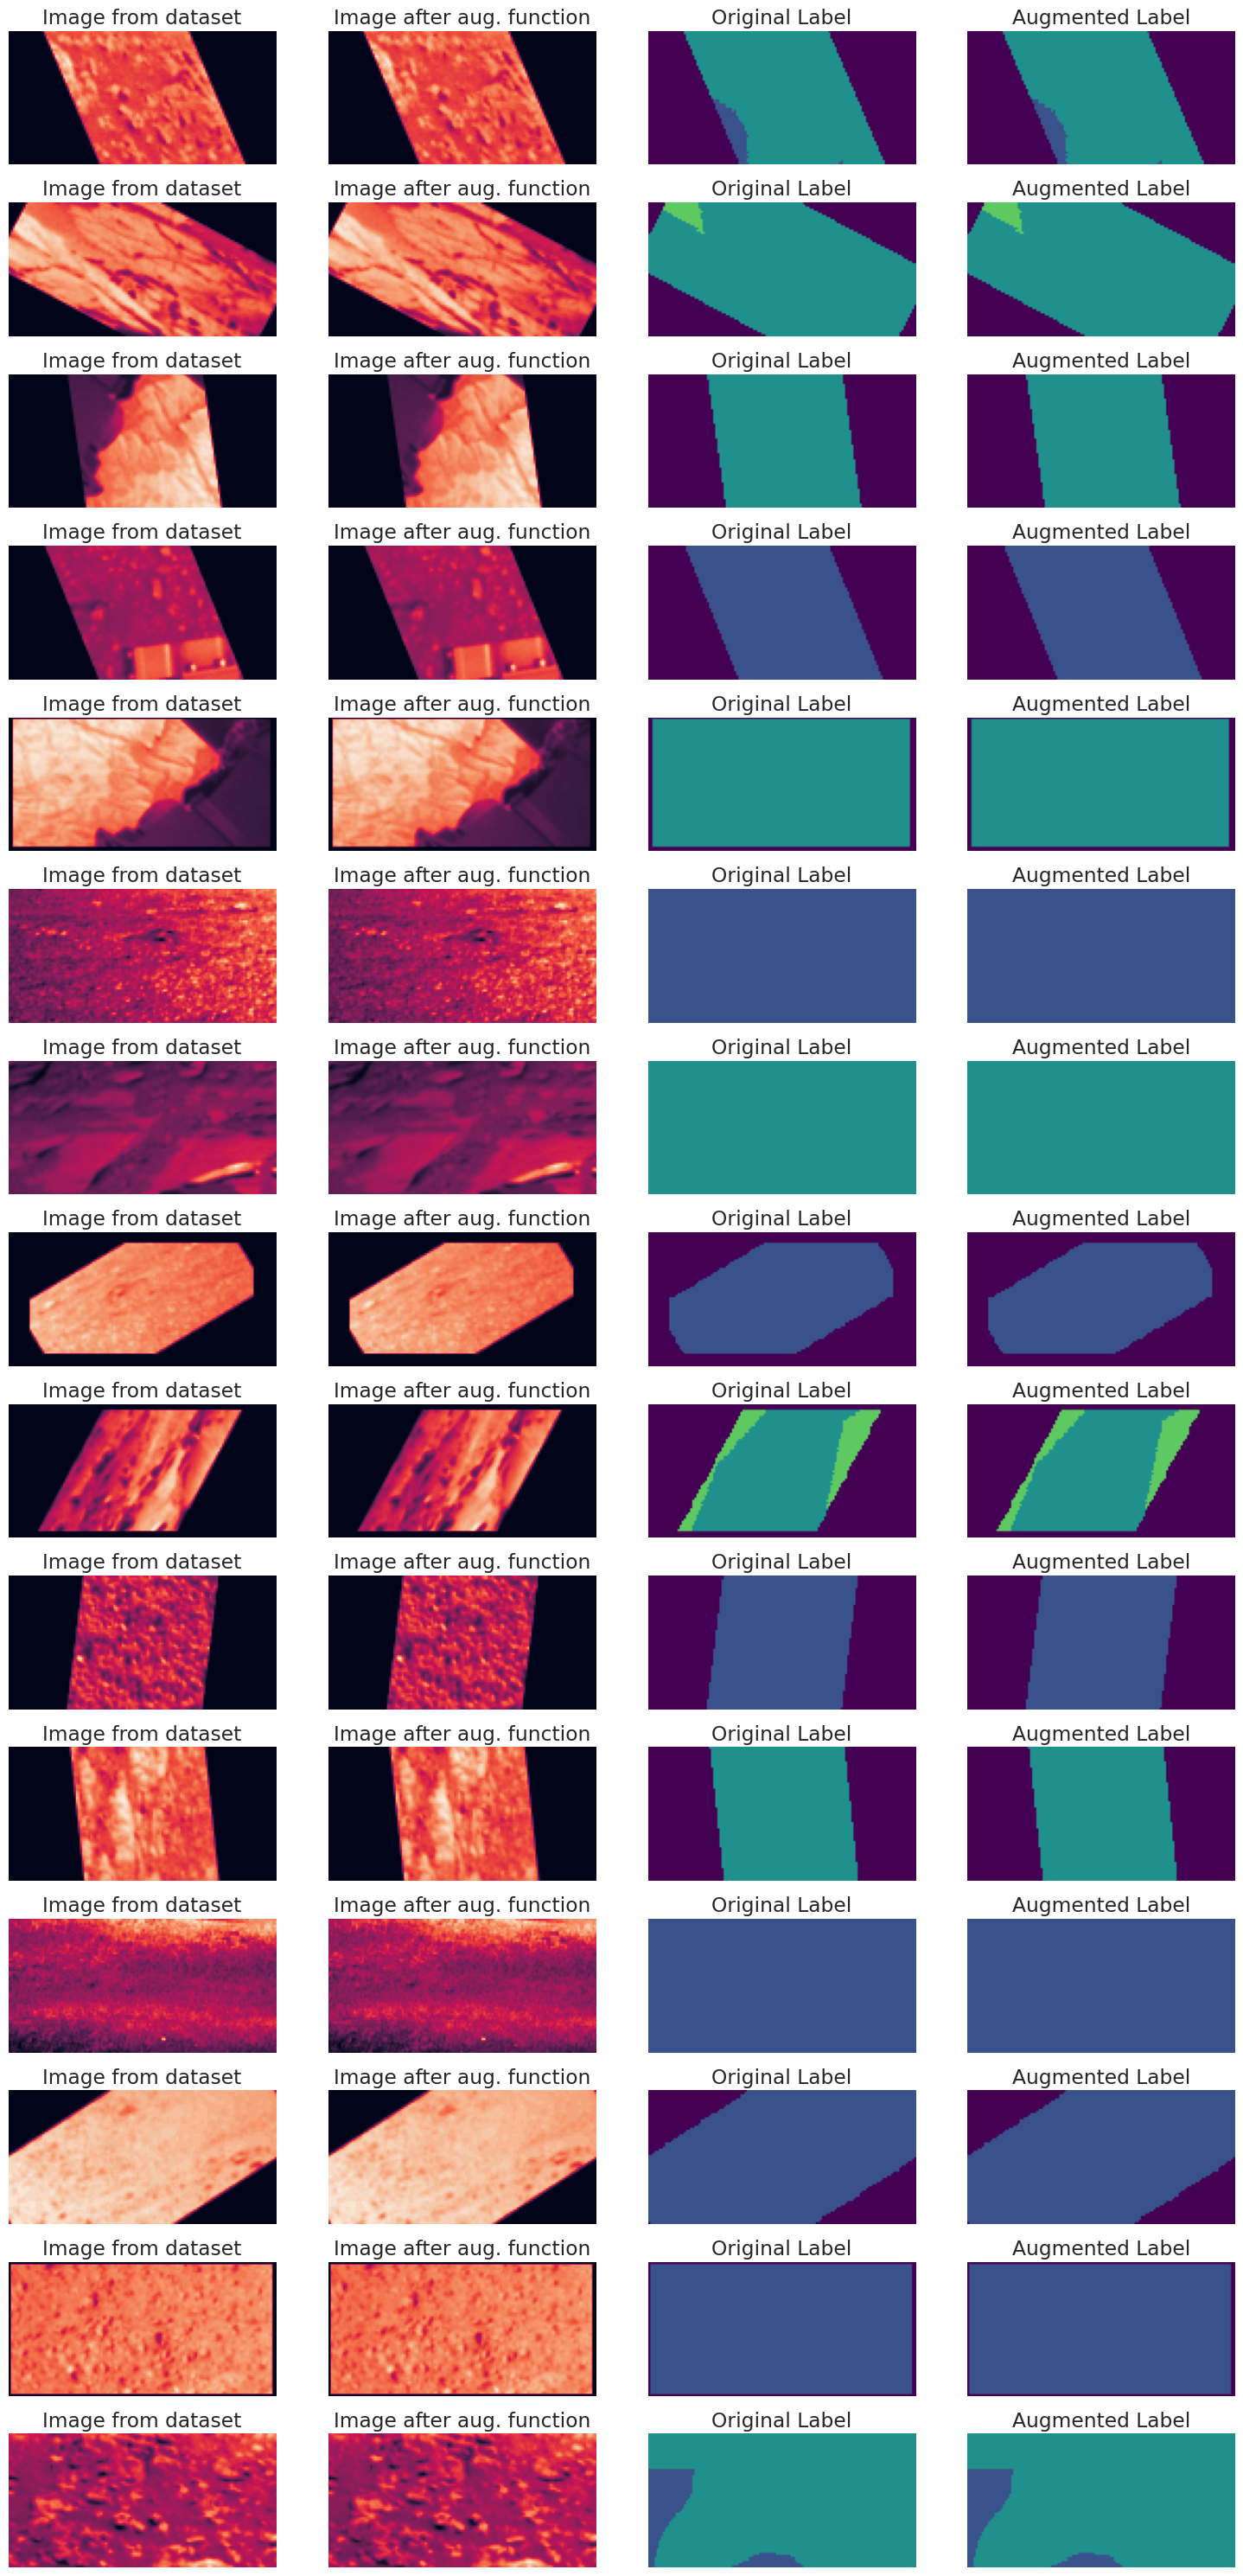

In [37]:
# Shuffle indices and select 20 random samples
random_indices = np.random.choice(X_train.shape[0], size=20, replace=False)

# Use the random indices to slice the data
X_random = X_train[random_indices]
y_random = y_train[random_indices]

show_dataset = make_dataset(
    X_random, y_random,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

# Calculate total elements by iterating through the dataset
num_elements = sum(tf.shape(x)[0].numpy() for x, y in show_dataset)
print(f"Total number of elements in the dataset: {num_elements}")

#visualize_augmented_images(zip(X_random, y_random), random_augmentations_before, num_examples=10, seed=42)
#visualize_augmented_images(show_dataset, random_augmentations_after, num_examples=20, seed=42)
visualize_augmented_images(show_dataset, lambda x, y, seed: (x, y), num_examples=15, seed=42)

Class percentages:
Class 0: 15.48%
Class 1: 36.58%
Class 2: 27.02%
Class 3: 20.34%
Class 4: 0.59%
Labels length is 4470
Class percentages:
Class 0: 34.69%
Class 1: 28.88%
Class 2: 18.33%
Class 3: 18.00%
Class 4: 0.10%
Labels length is 502


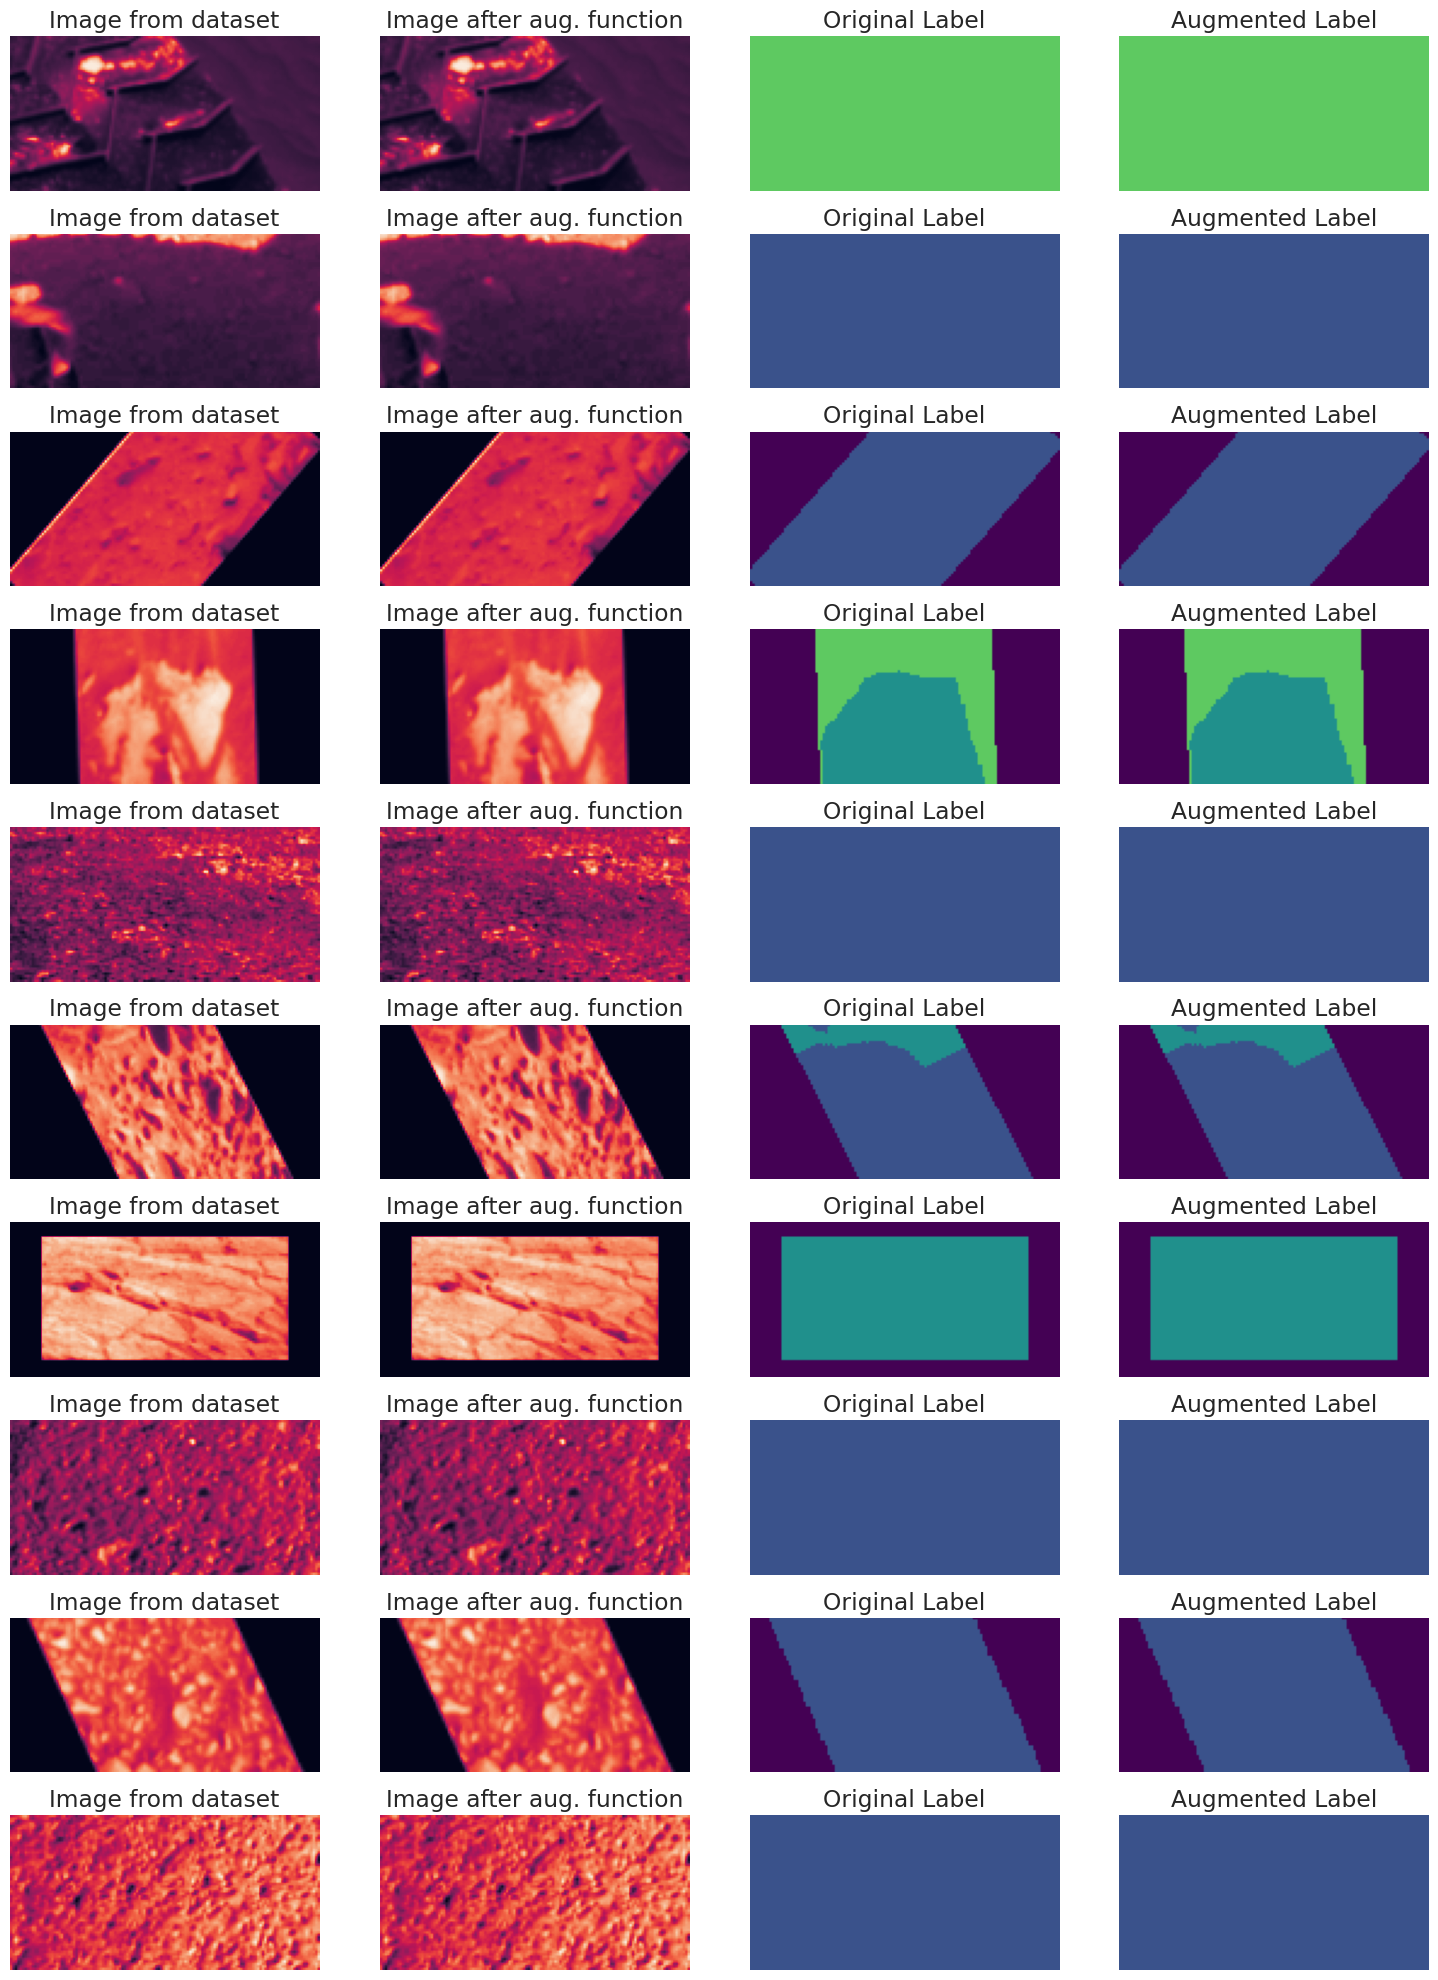

Total number of elements in the training dataset: 8940
Total number of elements in the validation dataset: 1004


In [38]:
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    #augment=False,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=25,
    shuffle=True,
    augment=True,
    #augment=False,
    seed=seed
)

visualize_augmented_images(train_dataset, lambda x, y, seed: (x, y), num_examples=10, seed=42)

# Calculate total elements by iterating through the dataset
num_elements = sum(tf.shape(x)[0].numpy() for x, y in train_dataset)
print(f"Total number of elements in the training dataset: {num_elements}")

# Calculate total elements by iterating through the dataset
num_elements = sum(tf.shape(x)[0].numpy() for x, y in val_dataset)
print(f"Total number of elements in the validation dataset: {num_elements}")

In [39]:
# Define the expected shapes
expected_img_shape = (256, 64, 128, 1)
expected_lbl_shape = (256, 64, 128, 5)

# Iterate through the dataset and check shapes
for i, (img_batch, lbl_batch) in enumerate(train_dataset):
    # Check if the shapes don't match the expected shapes
    if img_batch.shape != expected_img_shape or lbl_batch.shape != expected_lbl_shape:
        print(f"Batch {i}:")
        print("Image batch shape:", img_batch.shape)
        print("Label batch shape:", lbl_batch.shape)

Batch 34:
Image batch shape: (236, 64, 128, 1)
Label batch shape: (236, 64, 128, 5)


In [40]:
# Print the shape of a single batch from the train_dataset
for img_batch, lbl_batch in train_dataset.take(1):  # Taking the first batch
    print("Image batch shape:", img_batch.shape)
    print("Label batch shape:", lbl_batch.shape)

Image batch shape: (256, 64, 128, 1)
Label batch shape: (256, 64, 128, 5)


In [55]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES)

(None, 16, 1)
(None, 2048, 16)


ValueError: Exception encountered when calling MatMulLayer.call().

[1mCould not automatically infer the output shape / dtype of 'mat_mul_layer_23' (of type MatMulLayer). Either the `MatMulLayer.call()` method is incorrect, or you need to implement the `MatMulLayer.compute_output_spec() / compute_output_shape()` method. Error encountered:

Dimensions must be equal, but are 1 and 2048 for '{{node MatMul}} = BatchMatMulV2[T=DT_FLOAT, adj_x=false, adj_y=false, grad_x=false, grad_y=false](Placeholder, Placeholder_1)' with input shapes: [?,16,1], [?,2048,16].[0m

Arguments received by MatMulLayer.call():
  • args=(['<KerasTensor shape=(None, 16, 1), dtype=float32, sparse=False, name=keras_tensor_257>', '<KerasTensor shape=(None, 2048, 16), dtype=float32, sparse=False, name=keras_tensor_255>'],)
  • kwargs=<class 'inspect._empty'>

In [56]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)
        y_true = tf.math.argmax(y_true, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, images, labels, frequency=5):
        super().__init__()
        self.images = images
        self.labels = labels
        self.frequency = frequency

    def apply_colormap(self, label, colormap=None):
        """
        Apply the colormap to a label.
        """
        # Ensure label is 2D
        label = np.squeeze(label)

        if colormap is None:
            num_classes = len(np.unique(label))
            colormap = plt.cm.viridis(np.linspace(0, 1, num_classes))

        # Apply the colormap
        colored = colormap[label.astype(int)]

        return colored

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            idx = random.randint(0, len(self.images))
            image = self.images[idx]
            label = self.labels[idx]

            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)

            # Handle multi-output: choose the 'final' output for visualization
            if isinstance(pred, dict):
                if 'final_output' in pred:
                    y_pred = tf.math.argmax(pred['final_output'], axis=-1).numpy()
                else:
                    raise ValueError("The 'final_output' key is not present in the model output.")
            else:
                y_pred = tf.math.argmax(pred, axis=-1).numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = plt.cm.viridis(np.linspace(0, 1, num_classes))

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = self.apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = self.apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [57]:
total_percentage = sum(class_percentages.values())
class_weights = {cls: total_percentage / percentage for cls, percentage in class_percentages.items()}
print(class_weights)

# Convert class_weights to a tensor (use in TensorFlow/Keras)
class_weights_tensor = tf.constant([class_weights[c] for c in sorted(class_weights.keys())], dtype=tf.float32)
class_weights_tensor = class_weights_tensor / tf.norm(class_weights_tensor)

def compute_distance_map(y_true):
    """
    Approximate the distance map using TensorFlow operations.
    This applies a convolution-based smoothing filter.
    """
    # Ensure y_true is one-hot encoded and float
    y_true = tf.cast(y_true, tf.float32)

    # Define a simple Gaussian kernel for smoothing
    def gaussian_kernel(size: int, sigma: float):
        """
        Create a 2D Gaussian kernel using TensorFlow.
        """
        x = tf.range(-size // 2 + 1, size // 2 + 1, dtype=tf.float32)
        y = tf.range(-size // 2 + 1, size // 2 + 1, dtype=tf.float32)
        x, y = tf.meshgrid(x, y)
        kernel = tf.exp(-(x**2 + y**2) / (2.0 * sigma**2))
        kernel = kernel / tf.reduce_sum(kernel)
        return kernel

    kernel_size = 15
    sigma = 5.0
    gaussian = gaussian_kernel(kernel_size, sigma)
    gaussian = gaussian[:, :, tf.newaxis, tf.newaxis]

    distances = []
    for c in range(y_true.shape[-1]):
        class_map = y_true[..., c: c + 1]  # Extract single class channel
        # Apply Gaussian smoothing using 2D convolution
        smoothed = tf.nn.conv2d(
            class_map[tf.newaxis],  # Add batch dimension
            gaussian,
            strides=[1, 1, 1, 1],
            padding="SAME"
        )[0]  # Remove batch dimension
        distances.append(smoothed)

    return tf.stack(distances, axis=-1)

def boundary_loss(y_true, y_pred):
    """
    Boundary Loss: Penalizes differences along the boundary.
    """
    y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

    # Compute distance map
    distance_map = compute_distance_map(y_true)
    distance_map = tf.squeeze(distance_map, axis=3)

    # Compute boundary loss as the L2 loss between distance map and predicted boundaries
    boundary_diff = distance_map * (y_true - y_pred)
    boundary_loss_value = tf.reduce_mean(tf.square(boundary_diff))
    return boundary_loss_value

def dice_loss(y_pred, y_true):

    epsilon = 1e-6  # Per evitare divisioni per zero

    intersection = tf.reduce_sum(y_true * y_pred, axis=(0, 1, 2))
    pred_sum = tf.reduce_sum(y_pred**2, axis=(0, 1, 2))
    true_sum = tf.reduce_sum(y_true**2, axis=(0, 1, 2))

    dice = (2.0 * intersection + epsilon) / (pred_sum + true_sum + epsilon)

    loss = 1.0 - tf.reduce_mean(dice)
    return loss

def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    # Ensure predictions are within valid probability range
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

    # Compute cross-entropy
    cross_entropy = -y_true * tf.math.log(y_pred)

    # Compute the focal weight
    focal_weight = alpha * tf.pow(1 - y_pred, gamma)

    # Apply the focal weight to the cross-entropy
    loss = focal_weight * cross_entropy

    # Take the mean over all classes
    return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))

def weighted_categorical_crossentropy(y_true, y_pred):
    """
    Weighted Categorical Cross-Entropy Loss
    """
    # Clip the predictions to avoid log(0) errors
    y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

    # Compute categorical cross-entropy
    cross_entropy = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)

    # Apply class weights: element-wise multiplication
    # class_weights should be broadcastable to match the shape of y_true
    weights = tf.reduce_sum(class_weights_tensor * y_true, axis=-1)  # Weighting for each sample in the batch

    # Compute the weighted loss by multiplying cross-entropy by the weights
    weighted_cross_entropy = weights * cross_entropy

    # Return the mean of the weighted loss over the batch
    return tf.reduce_mean(weighted_cross_entropy)

def weighted_loss_multiscale(y_true, y_pred, y_pred_coarse, y_pred_fine, y_pred_final, alpha, beta, gamma, loss_fn):
    # Compute loss for each scale

    """print(f"y_true shape is {y_true.shape}")
    print(f"y_pred shape is {y_pred.shape}")
    print(f"y_pred_coarse shape is {y_pred_coarse.shape}")
    print(f"y_pred_fine shape is {y_pred_fine.shape}")
    print(f"y_pred_final shape is {y_pred_final.shape}")"""
    loss_coarse = loss_fn(y_true, y_pred_coarse)

    """print(f"y_true shape is {y_true.shape}")
    print(f"y_pred_fine shape is {y_pred_fine.shape}")"""
    loss_fine = loss_fn(y_true, y_pred_fine)

    """print(f"y_true shape is {y_true.shape}")
    print(f"y_pred_final shape is {y_pred_final.shape}")"""
    loss_final = loss_fn(y_true, y_pred_final)

    # Combine losses with appropriate weights
    total_loss = alpha * loss_coarse + beta * loss_fine + gamma * loss_final
    return total_loss

def combined_loss(y_true, y_pred, lambda_=0.5):
    """
    Combined Loss: Weighted Categorical Cross-Entropy + Dice Loss
    """
    loss_boundary = boundary_loss(y_true, y_pred)
    loss_dice = dice_loss(y_true, y_pred)
    loss_focal = focal_loss(y_true, y_pred)
    loss_wcce = weighted_categorical_crossentropy(y_true, y_pred)

    #loss_combined = 0.25 * loss_boundary + loss_dice + (2 * loss_focal) + loss_wcce
    #loss_combined = 0.25 * (loss_boundary + loss_dice + loss_focal + loss_wcce)
    #return lambda_ * loss_wcce + (1 - lambda_) * loss_dice

    loss_combined = 0.5 * (loss_focal + loss_dice)

    return loss_combined

# Compile the model with the custom combined loss
print("Compiling model...")
with strategy.scope():
    model.compile(
        loss=combined_loss,
        optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
        metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
    )

    """loss=lambda y_true, y_pred: weighted_loss_multiscale(
            y_true,
            y_pred,
            y_pred[0],
            y_pred[1],
            y_pred[2],
            alpha=0.6,
            beta=0.3,
            gamma=0.1,
            loss_fn=weighted_categorical_crossentropy
        ),"""

    """metrics={
            'coarse_upactivation2': [MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])],
            'fine_intermediate': [MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])],
            'final_output': [MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
        }"""

print("Model compiled!")

{1.0: 2.3069223597006276, 2.0: 3.128199468095103, 3.0: 4.165271161720614, 4.0: 147.73401757401174}
Compiling model...


NameError: name 'model' is not defined

In [ ]:
# Setup callbacks
with strategy.scope():
    early_stopping = tf.keras.callbacks.EarlyStopping(
        #monitor='val_accuracy',
        monitor='val_mean_iou',
        mode='max',
        patience=PATIENCE,
        restore_best_weights=True
    )

    viz_callback = VizCallback(X_val, y_val)

In [ ]:
dataset_size = train_dataset.cardinality().numpy()  # Get the size of the dataset as a Python integer
print(f"Dataset size: {dataset_size}")

In [ ]:
print(model.output_names)

In [ ]:
# Train the model
with strategy.scope():
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=[early_stopping, viz_callback],
        #verbose=1
        verbose=2
    ).history

    # Calculate and print the final validation accuracy
    final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
    print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
def get_lists_from_data(test_data):
    """
    Extracts from test_data a list of shapes len(test_data) x 64 x 128
    with the value of each pixel corresponding to the one in the validation
    set if it's y_true, to the one predicted if it's y_pred, and the original
    input images in inputs.

    Args:
        test_data: Dataset containing test inputs and labels.

    Returns:
        y_true: List of true labels with shape (num_elements, 64, 128).
        y_pred: List of predicted labels with shape (num_elements, 64, 128).
        inputs: List of input images with shape (num_elements, 64, 128).
    """
    y_true = []
    y_pred = []
    inputs = []

    for input_batch, label_batch in test_data:
        # Get model predictions
        predictions = model.predict(input_batch)

        # Process inputs
        inputs.extend(input_batch.numpy())  # Add original inputs as NumPy arrays

        # Process labels and predictions
        y_true.extend(np.argmax(label_batch.numpy(), axis=-1))  # Convert labels to indices
        y_pred.extend(np.argmax(predictions, axis=-1))          # Convert predictions to indices

    return inputs, y_true, y_pred

In [ ]:
def show_major_errors(test_data, model, n=10):
    """
    Identify and display the `n` largest prediction errors.

    Args:
        test_data: Dataset containing test inputs and labels.
        model: The trained model for making predictions.
        n: The number of major mistakes to display.
    """
    # Get predictions and true values
    inputs, y_true, y_pred = get_lists_from_data(test_data)

    save_path = "./Saved_pred/data.npz"
    """data = np.load(save_path)
    inputs = data["inputs"]
    y_true = data["y_true"]
    y_pred = data["y_pred"]

    n=50"""

    np.savez_compressed(save_path, inputs=np.array(inputs), y_true=np.array(y_true), y_pred=np.array(y_pred))
    print(f"Data saved to {save_path}")

    # Calculate difference scores
    difference_scores = [
        np.sum(y_t != y_p)  # Count mismatched pixels for each sample
        for y_t, y_p in zip(y_true, y_pred)
    ]

    # Find indices of the `n` largest differences
    #top_n_indices = np.argsort(difference_scores)[-n:] # worst classifications
    #top_n_indices = np.argsort(difference_scores)[:n] # best classifications
    top_n_indices = np.random.choice(len(difference_scores), size=n, replace=False)  # replace=False ensures no duplicates

    y_true = np.eye(NUM_CLASSES)[y_true]
    y_pred = np.eye(NUM_CLASSES)[y_pred]

    # Display the top `n` mistakes
    fig, axes = plt.subplots(n, 3, figsize=(15, 5 * n))
    for i, idx in enumerate(top_n_indices):
        original_input = inputs[idx] # We extract the original image removing the single dimension
        true_label = y_true[idx] # We extract the true label not making it one hot encoded anymore
        #print(f"True label shape is {true_label.shape}")

        # Generate prediction for visualization
        predicted_label = y_pred[idx]

        # Plot original image
        axes[i, 0].imshow(original_input.squeeze())
        axes[i, 0].set_title(f"Input Image {idx}, difference: {difference_scores[idx]}")
        axes[i, 0].axis("off")

        # Plot true mask
        #print(f"True label is {true_label} end")
        axes[i, 1].imshow(apply_colormap(true_label), cmap='viridis')
        axes[i, 1].set_title(f"True Mask {idx}")
        axes[i, 1].axis("off")

        # Plot predicted mask
        axes[i, 2].imshow(apply_colormap(predicted_label), cmap='viridis')
        axes[i, 2].set_title(f"Prediction {idx}")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

show_major_errors(val_dataset, model)

In [ ]:
def plot_confusion_matrix(model, test_data, class_names):
    """
    Plots the confusion matrix for the given model and test data, calculates accuracy and mIoU for each class.

    Args:
        model: Trained Keras model.
        test_data: A `tf.data.Dataset` or similar iterable with (inputs, labels).
        class_names: List of class names corresponding to the labels.
    """

    input, y_true, y_pred = get_lists_from_data(test_data)

    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate accuracy for each class
    class_accuracies = np.diag(cm) / np.sum(cm, axis=1)

    # Print the accuracy for each class
    for i, class_name in enumerate(class_names):
        print(f"Accuracy for class {class_name}: {class_accuracies[i] * 100:.2f}%")

    # Intersection: True Positives (diagonal elements)
    intersection = np.diag(cm)

    # Union: True Positives + False Positives + False Negatives
    false_positives = np.sum(cm, axis=0) - intersection
    false_negatives = np.sum(cm, axis=1) - intersection
    union = intersection + false_positives + false_negatives

    # Avoid division by zero
    union = np.where(union == 0, 1, union)

    # Calculate IoU for each class
    iou_per_class = intersection / union

    # Print IoU for each class
    for i, class_name in enumerate(class_names):
        print(f"mIoU for class {class_name}: {iou_per_class[i] * 100:.2f}%")

    # Normalize the confusion matrix row-wise
    row_sums = np.sum(cm, axis=1, keepdims=True)  # Sum of each row, shape (N, 1)
    cm = cm / row_sums  # Normalize each row to represent proportions

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Confusion Matrix")

    # Adjust text font size inside each matrix cell
    for label in disp.ax_.texts:
        label.set_fontsize(10)  # Adjust font size of the numbers inside the squares

    plt.show()

plot_confusion_matrix(model, val_dataset, [0, 1,2,3,4])

In [ ]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
submission_filename = f"submission_{timestep_str}.csv"
submission_filename_zip = f"submission_{timestep_str}.zip"

submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

!zip {submission_filename_zip} {submission_filename}

files.download(submission_filename_zip)